# Required Capstone Component 21


## New Information
- Decided to look at median distance rather than closest distance - because a point could be close to one point that's very far away, and then the closest distance will make it look like I'm not choosing a point in an area with very little information.

## Old Information
From my one-on-one, I have the following tips:
- $\kappa = 1$ will balance exploration and exploitation (https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html)
- Checked posterior standard deviation - high standard deviation suggests that I should choose $\kappa$ to prioritise exploration. 
- I used the coefficient of variation to check whether my standard deviation was high or not (https://www.statology.org/what-is-a-good-standard-deviation/#:~:text=CV:%201%202%20%2C%200%200,the%20data%20is%20quite%20low.)
- I used latinHypercube to get samples for my GP for dimensions 4 and higher.

## Import Data

In [1]:
# Import any necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, Matern
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PowerTransformer
from scipy.stats import norm
from statistics import mean
from scipy.stats import qmc
import itertools
import math
import ast
from scipy.spatial.distance import pdist, squareform


# load initial inputs
x_1 = np.load("updated_data/week_20/function_1_inputs_week_20.npy")
x_2 = np.load("updated_data/week_20/function_2_inputs_week_20.npy")
x_3 = np.load("updated_data/week_20/function_3_inputs_week_20.npy")
x_4 = np.load("updated_data/week_20/function_4_inputs_week_20.npy")
x_5 = np.load("updated_data/week_20/function_5_inputs_week_20.npy")
x_6 = np.load("updated_data/week_20/function_6_inputs_week_20.npy")
x_7 = np.load("updated_data/week_20/function_7_inputs_week_20.npy")
x_8 = np.load("updated_data/week_20/function_8_inputs_week_20.npy")

# load initial outputs
y_1 = np.load("updated_data/week_20/function_1_outputs_week_20.npy")
y_2 = np.load("updated_data/week_20/function_2_outputs_week_20.npy")
y_3 = np.load("updated_data/week_20/function_3_outputs_week_20.npy")
y_4 = np.load("updated_data/week_20/function_4_outputs_week_20.npy")
y_5 = np.load("updated_data/week_20/function_5_outputs_week_20.npy")
y_6 = np.load("updated_data/week_20/function_6_outputs_week_20.npy")
y_7 = np.load("updated_data/week_20/function_7_outputs_week_20.npy")
y_8 = np.load("updated_data/week_20/function_8_outputs_week_20.npy")


In [2]:
x_new = [np.array([0.232323, 0.262626]), 
np.array([0.696970, 0.111111]), 
np.array([0.292929, 0.434343, 0.545455]), 
np.array([0.369010, 0.358282, 0.391104, 0.347264]), 
np.array([0.613460, 0.998399, 0.991291, 0.999527]), 
np.array([0.245193, 0.250390, 0.624303, 0.996633, 0.001774]), 
np.array([0.011133, 0.236781, 0.248012, 0.199653, 0.282008, 0.660681]), 
np.array([0.132329, 0.155548, 0.013550, 0.267072, 0.754837, 0.290680, 0.175114, 0.444593])]


y_new = [np.float64(1.1616351371911581e-43), 
np.float64(0.6593112815270088), 
np.float64(-0.02306930096927113), 
np.float64(0.5338486222644581), 
np.float64(4819.797300816593), 
np.float64(-0.5300618284876105), 
np.float64(2.3416597019909298), 
np.float64(9.8950027602886)]


print(x_new)
print(y_new)

print(type(x_new))
print(type(y_new))

print(x_new[2]) 
print(y_new[2])








[array([0.232323, 0.262626]), array([0.69697 , 0.111111]), array([0.292929, 0.434343, 0.545455]), array([0.36901 , 0.358282, 0.391104, 0.347264]), array([0.61346 , 0.998399, 0.991291, 0.999527]), array([0.245193, 0.25039 , 0.624303, 0.996633, 0.001774]), array([0.011133, 0.236781, 0.248012, 0.199653, 0.282008, 0.660681]), array([0.132329, 0.155548, 0.01355 , 0.267072, 0.754837, 0.29068 ,
       0.175114, 0.444593])]
[np.float64(1.1616351371911581e-43), np.float64(0.6593112815270088), np.float64(-0.02306930096927113), np.float64(0.5338486222644581), np.float64(4819.797300816593), np.float64(-0.5300618284876105), np.float64(2.3416597019909298), np.float64(9.8950027602886)]
<class 'list'>
<class 'list'>
[0.292929 0.434343 0.545455]
-0.02306930096927113


## Create Functions


In [3]:
from pickle import NONE
from statistics import median


def find_median_neighbor_distances(points):
    """
    Find the median distance from each point to its neighbors.
    
    Args:
        points: numpy array of shape (n_points, n_dimensions)
    
    Returns:
        distances: array of median distances to neighbors for each point
    """
    # Compute pairwise distances
    distances_matrix = squareform(pdist(points))
    
    # Set diagonal to infinity to exclude self-distances
    np.fill_diagonal(distances_matrix, np.inf)
    
    # Find minimum distance for each point (closest neighbor)
    median_distances = np.median(distances_matrix, axis=1)
    
    return median_distances



def find_median_distance_to_array(single_point, array_of_points):
    """
    Find the median distance from a single point to an array of points.
    
    Args:
        single_point: numpy array of shape (n_dimensions,)
        array_of_points: numpy array of shape (n_points, n_dimensions)
    
    Returns:
        median_distance: scalar, median distance
    """
    # Calculate distances from single point to all points in array
    distances = np.sqrt(np.sum((array_of_points - single_point)**2, axis=1))
    
    # Find median distance and its index
    median_distance = np.median(distances)
    
    return median_distance




def plot_boxplot_with_new_point(data, new_query_point, old_query_point, title="Boxplot with New Point", 
                                ylabel="nearest neighbor distance",
                               new_point_label=None, figsize=(10, 6), overlay=False):
    """
    Create a boxplot with a new point overlaid in red.

    Parameters:
    -----------
    data : array-like
        The data to create the boxplot from
    new_data : float
        The new point value to overlay
    title : str, optional
        Title for the plot (default: "Boxplot with New Point")
    ylabel : str, optional
        Label for y-axis (default: "nearest neighbor distance")
    new_point_label : str, optional
        Custom label for the new point (default: auto-generated)
    figsize : tuple, optional
        Figure size (default: (10, 6))
    overlay : bool, optional
        If True, overlay each data point on top of the boxplot in a light colour
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """

    # Create figure
    plt.figure(figsize=figsize)
    
    # Create the boxplot
    box_plot = plt.boxplot(data, patch_artist=True)
    
    # Style the boxplot
    box_plot['boxes'][0].set_facecolor('lightblue')
    box_plot['boxes'][0].set_alpha(0.7)
    
    # Optionally overlay all data points in a light colour
    if overlay:
        x_jitter = np.random.normal(0, 0.03, size=len(data))
        x_positions = 1 + x_jitter
        plt.scatter(x_positions, data, color='#7f8c8d', alpha=0.4, s=30, zorder=4, label='_nolegend_')
    
    # add new data: 
    for i in range(len(old_query_point)):
        # Convert old_query_point to float if it's numpy type
        new_value = float(old_query_point[i])
    
        # Add the new point in blue
        plt.scatter(1, new_value, color='blue', s=100, zorder=5, label="Previous Query Points")
    
        # Add value label for the new point
        plt.annotate(f'point {i+1} = {new_value:.6e}', 
                    xy=(1, new_value), 
                    xytext=(1.1, new_value),
                    arrowprops=dict(arrowstyle='->', color='blue', alpha=0.7),
                    fontsize=10, 
                    color='blue',
                    ha='left')

    
    # Convert old_query_point to float if it's numpy type
    new_value = float(new_query_point[0])
    
    # Add the new point in red
    plt.scatter(1, new_value, color='red', s=100, zorder=5, label="New Query Point")
    
    # Add value label for the new point
    plt.annotate(f'{new_value:.6e}', 
                xy=(1, new_value), 
                xytext=(1.1, new_value),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                fontsize=10, 
                color='red',
                ha='left')
    
    # Customize the plot
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    # Show the plot
    plt.show()




def plot_boxplot(data, 
                title="Boxplot with New Point", 
                ylabel="nearest neighbor distance",
                figsize=(10, 6)):
    """
    Create a boxplot with a new point overlaid in red.
    
    Parameters:
    -----------
    data : array-like
        The data to create the boxplot from
    title : str, optional
        Title for the plot (default: "Boxplot with New Point")
    ylabel : str, optional
        Label for y-axis (default: "nearest neighbor distance")
    figsize : tuple, optional
        Figure size (default: (10, 6))
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    plt.figure(figsize=figsize)
    plt.boxplot(data, vert=True, patch_artist=True, 
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(color='black', linewidth=1.5),
                capprops=dict(color='black', linewidth=1.5),
                flierprops=dict(marker='o', markerfacecolor='red', markersize=4, alpha=0.6))
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()




# Replace your grid code with Latin Hypercube Sampling
def create_lhs_grid(n_samples, n_dimensions, seed=42):
    """
    Create Latin Hypercube Sampling grid.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples 
    n_dimensions : int
        Number of dimensions 
    seed : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    numpy array of shape (n_samples, n_dimensions)
    """
    # Create Latin Hypercube sampler
    sampler = qmc.LatinHypercube(d=n_dimensions, seed=seed)
    
    # Generate samples in [0, 1]^d
    samples = sampler.random(n=n_samples)
    
    return samples


# Compare Old Values to New

### Function 1

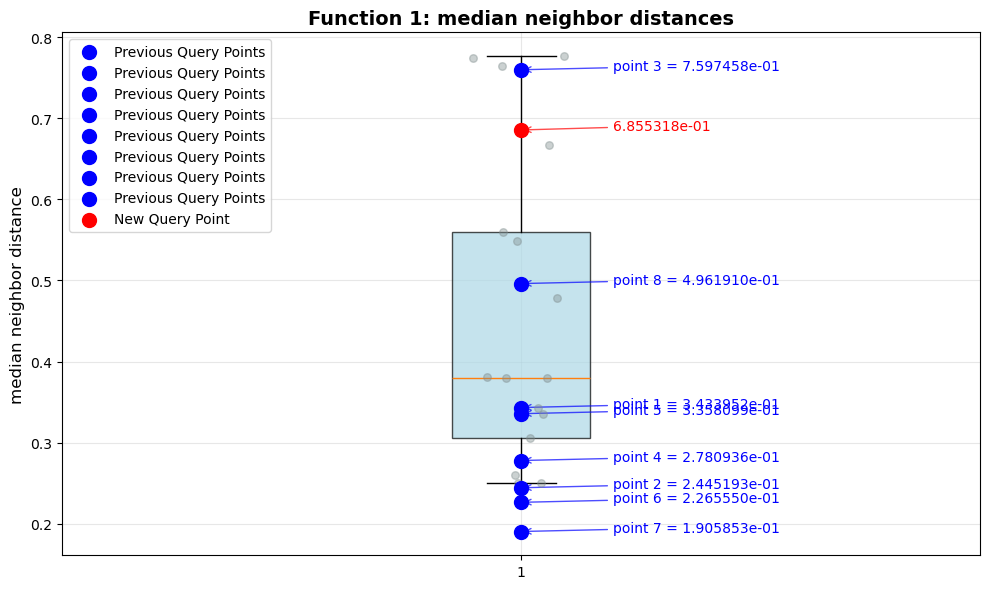

In [13]:
x1_distances = find_median_neighbor_distances(np.array(x_1))
new_x1_distance = np.array([find_median_distance_to_array(x_new[0], np.array(x_1))])
old_x1_distance = np.array([find_median_distance_to_array(x_1[-8], np.array(x_1)), find_median_distance_to_array(x_1[-7], np.array(x_1)), find_median_distance_to_array(x_1[-6], np.array(x_1)),find_median_distance_to_array(x_1[-5], np.array(x_1)), find_median_distance_to_array(x_1[-4], np.array(x_1)), find_median_distance_to_array(x_1[-3], np.array(x_1)), find_median_distance_to_array(x_1[-2], np.array(x_1)), find_median_distance_to_array(x_1[-1], np.array(x_1))])

plot_boxplot_with_new_point(
    x1_distances, 
    new_x1_distance,
    old_x1_distance, 
    'Function 1: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

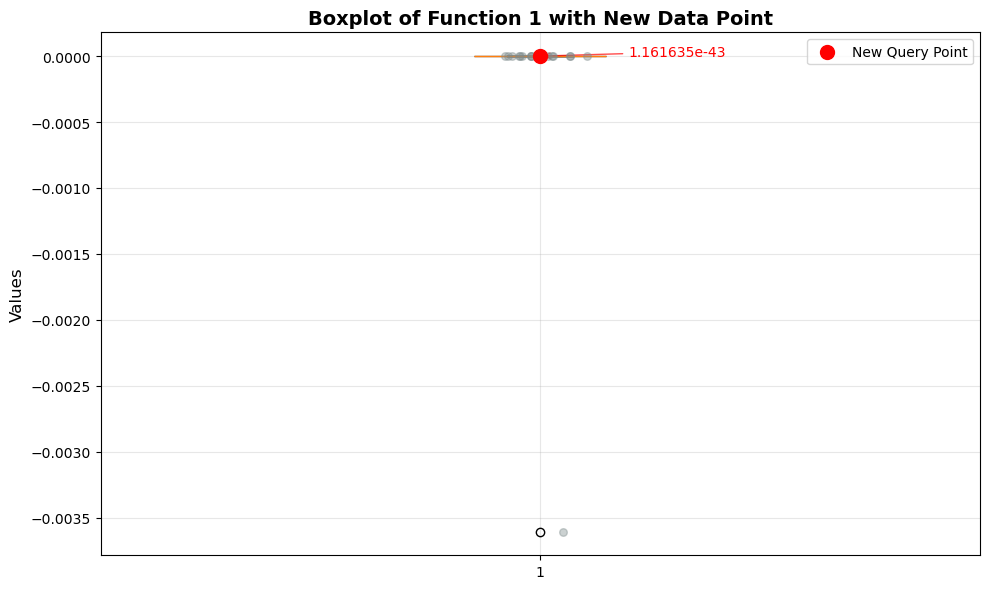

Old maximum: 7.710875e-16
New point: 1.161635e-43
Percentile rank in y_1: 82.4%

Old position: [0.73102363 0.73299988]
New position: [0.232323 0.262626]


In [14]:

plot_boxplot_with_new_point(
    y_1, 
    [y_new[0]], 
    np.array([]), # data very skew, so leave out old points
    'Boxplot of Function 1 with New Data Point', 
    'Values', 
    overlay=True)

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_1):.6e}")
print(f"New point: {y_new[0]:.6e}")
print(f"Percentile rank in y_1: {100 * (y_1 < y_new[0]).sum() / len(y_1):.1f}%")
print(f"\nOld position: {x_1[np.argmax(y_1)]}")
print(f"New position: {x_new[0]}")

### Function 2

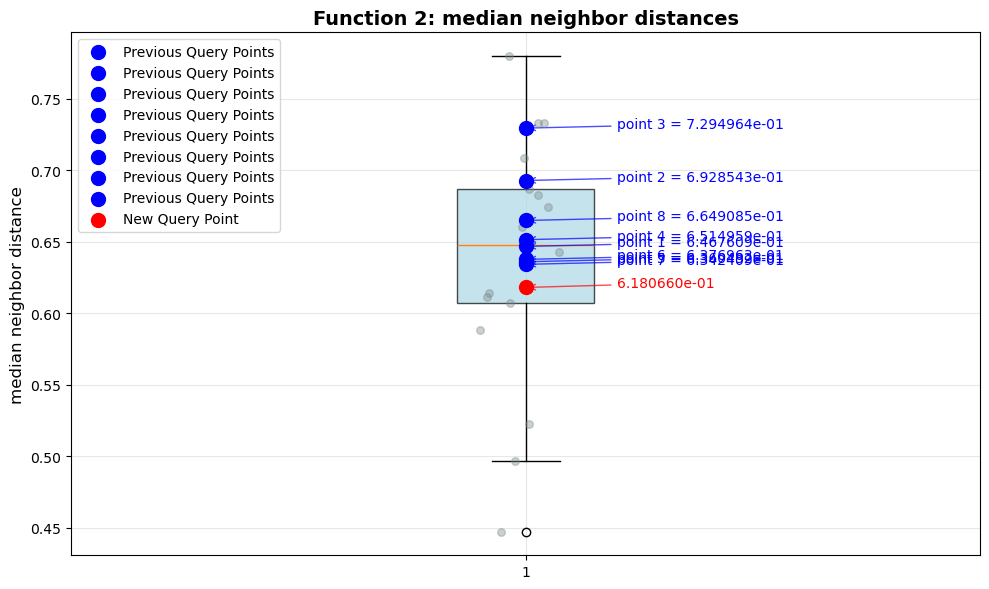

In [15]:
x2_distances = find_median_neighbor_distances(np.array(x_2))
new_x2_distance = np.array([find_median_distance_to_array(x_new[1], np.array(x_2))])
old_x2_distance = np.array([find_median_distance_to_array(x_2[-8], np.array(x_2)), find_median_distance_to_array(x_2[-7], np.array(x_2)), find_median_distance_to_array(x_2[-6], np.array(x_2)), find_median_distance_to_array(x_2[-5], np.array(x_2)), find_median_distance_to_array(x_2[-4], np.array(x_2)), find_median_distance_to_array(x_2[-3], np.array(x_2)), find_median_distance_to_array(x_2[-2], np.array(x_2)), find_median_distance_to_array(x_2[-1], np.array(x_2))])

plot_boxplot_with_new_point(
    x2_distances, 
    new_x2_distance,
    old_x2_distance, 
    'Function 2: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)


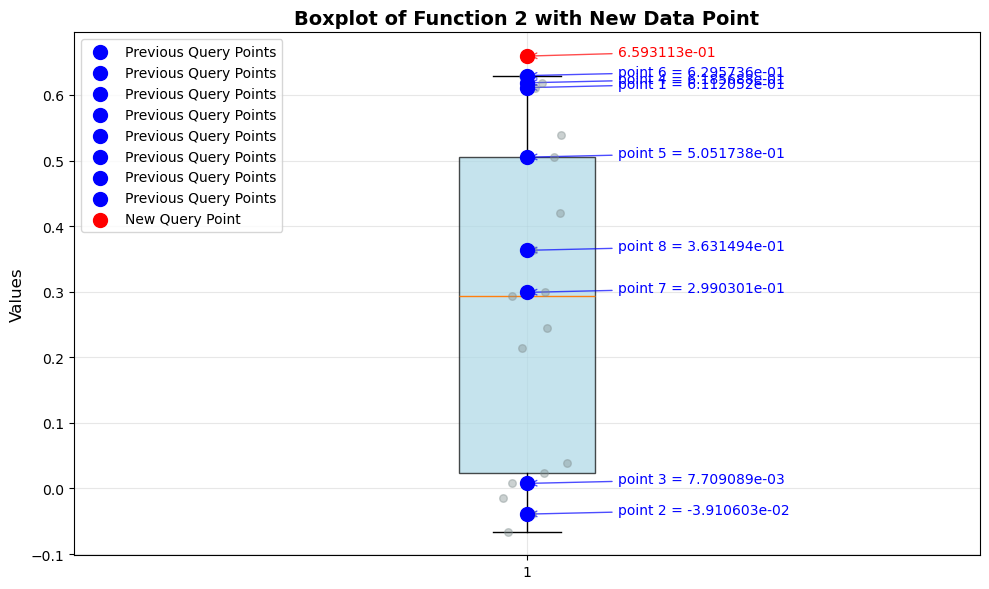

Old maximum: 6.295736e-01
New point: 6.593113e-01
Percentile rank in y_2: 100.0%

Old position: [0.69697  0.090909]
New position: [0.69697  0.111111]


In [16]:

plot_boxplot_with_new_point(
    y_2, 
    [y_new[1]], 
    np.array([y_2[-8], y_2[-7], y_2[-6], y_2[-5], y_2[-4], y_2[-3], y_2[-2], y_2[-1]]), 
    'Boxplot of Function 2 with New Data Point', 
    'Values', 
    overlay=True)

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_2):.6e}")
print(f"New point: {y_new[1]:.6e}")
print(f"Percentile rank in y_2: {100 * (y_2 < y_new[1]).sum() / len(y_2):.1f}%")
print(f"\nOld position: {x_2[np.argmax(y_2)]}")
print(f"New position: {x_new[1]}")

### Function 3

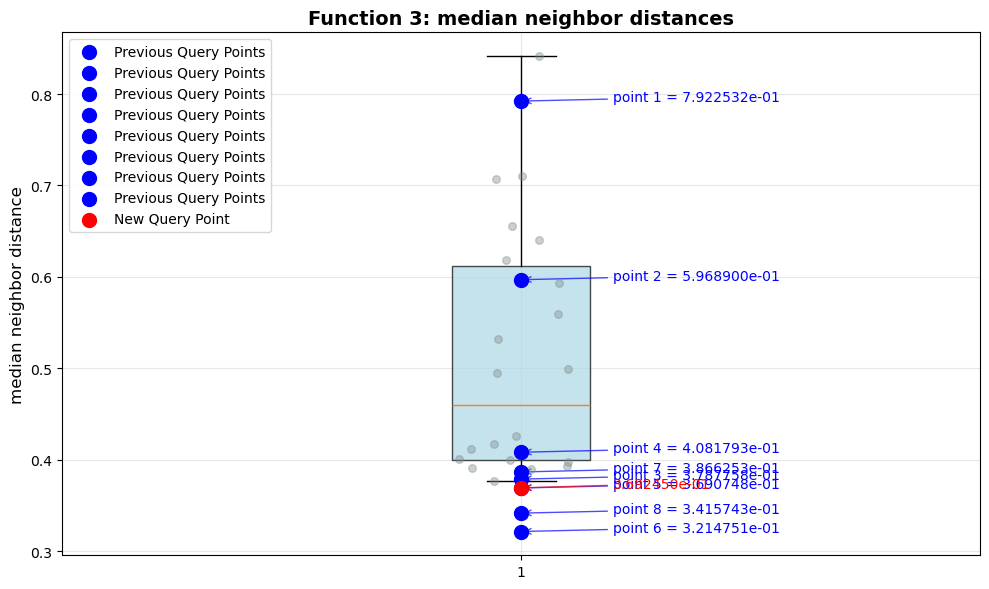

In [17]:
x3_distances = find_median_neighbor_distances(np.array(x_3))
new_x3_distance = np.array([find_median_distance_to_array(x_new[2], np.array(x_3))])
old_x3_distance = np.array([find_median_distance_to_array(x_3[-8], np.array(x_3)),find_median_distance_to_array(x_3[-7], np.array(x_3)), find_median_distance_to_array(x_3[-6], np.array(x_3)), find_median_distance_to_array(x_3[-5], np.array(x_3)), find_median_distance_to_array(x_3[-4], np.array(x_3)), find_median_distance_to_array(x_3[-3], np.array(x_3)), find_median_distance_to_array(x_3[-2], np.array(x_3)), find_median_distance_to_array(x_3[-1], np.array(x_3))])

plot_boxplot_with_new_point(
    x3_distances, 
    new_x3_distance,
    old_x3_distance, 
    'Function 3: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

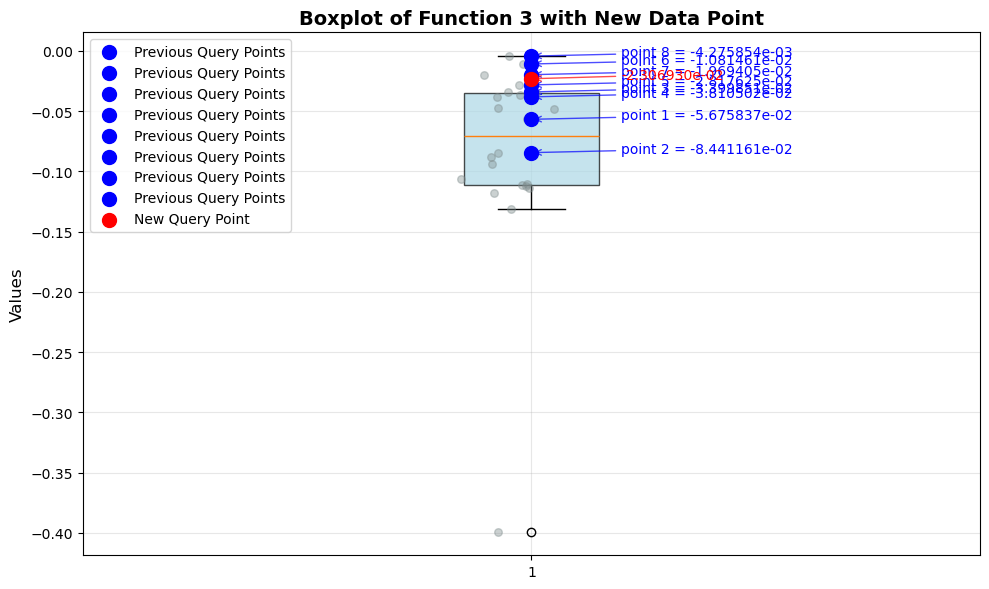

Old maximum: -4.275854e-03
New point: -2.306930e-02
Percentile rank in y_3: 86.4%

Old position: [0.313131 0.454545 0.484848]
New position: [0.292929 0.434343 0.545455]


In [18]:
plot_boxplot_with_new_point(
    y_3, 
    [y_new[2]], 
    np.array([y_3[-8], y_3[-7], y_3[-6], y_3[-5], y_3[-4], y_3[-3], y_3[-2], y_3[-1]]), 
    'Boxplot of Function 3 with New Data Point', 
    'Values', 
    overlay=True)

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_3):.6e}")
print(f"New point: {y_new[2]:.6e}")
print(f"Percentile rank in y_3: {100 * (y_3 < y_new[2]).sum() / len(y_3):.1f}%")
print(f"\nOld position: {x_3[np.argmax(y_3)]}")
print(f"New position: {x_new[2]}")

### Function 4

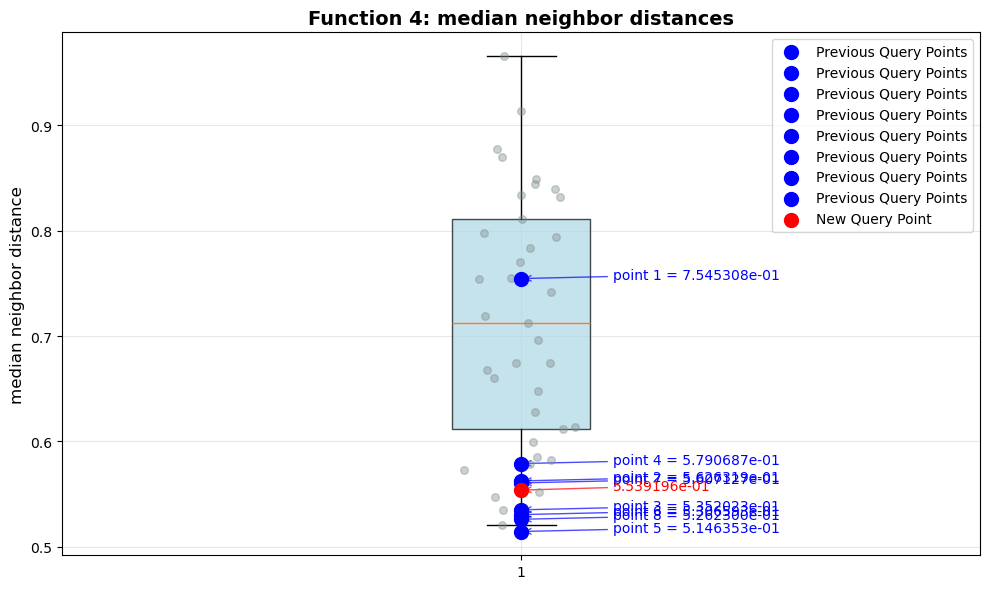

In [19]:
x4_distances = find_median_neighbor_distances(np.array(x_4))
new_x4_distance = np.array([find_median_distance_to_array(x_new[3], np.array(x_4))])
old_x4_distance = np.array([find_median_distance_to_array(x_4[-8], np.array(x_4)),find_median_distance_to_array(x_4[-7], np.array(x_4)), find_median_distance_to_array(x_4[-6], np.array(x_4)), find_median_distance_to_array(x_4[-5], np.array(x_4)), find_median_distance_to_array(x_4[-4], np.array(x_4)), find_median_distance_to_array(x_4[-3], np.array(x_4)), find_median_distance_to_array(x_4[-2], np.array(x_4)), find_median_distance_to_array(x_4[-1], np.array(x_4))])

plot_boxplot_with_new_point(
    x4_distances, 
    new_x4_distance,
    old_x4_distance, 
    'Function 4: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

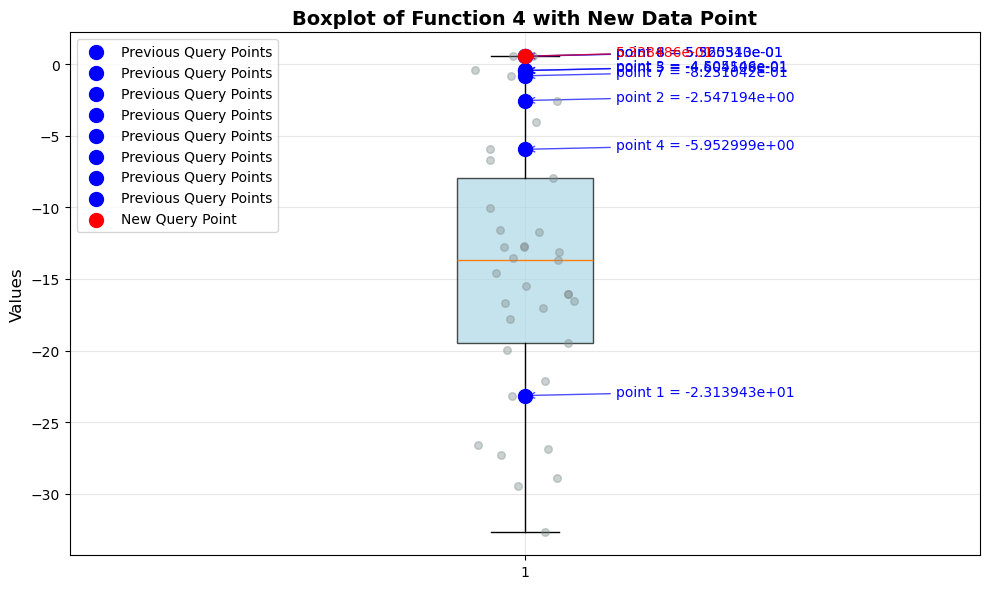

Old maximum: 5.520510e-01
New point: 5.338486e-01
Percentile rank in y_4: 94.6%

Old position: [0.371491 0.387495 0.422577 0.413388]
New position: [0.36901  0.358282 0.391104 0.347264]


In [20]:

plot_boxplot_with_new_point(
    y_4, 
    [y_new[3]], 
    np.array([y_4[-8], y_4[-7], y_4[-6], y_4[-5], y_4[-4], y_4[-3], y_4[-2], y_4[-1]]), 
    'Boxplot of Function 4 with New Data Point', 
    'Values', 
    overlay=True)

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_4):.6e}")
print(f"New point: {y_new[3]:.6e}")
print(f"Percentile rank in y_4: {100 * (y_4 < y_new[3]).sum() / len(y_4):.1f}%")
print(f"\nOld position: {x_4[np.argmax(y_4)]}")
print(f"New position: {x_new[3]}")

### Function 5

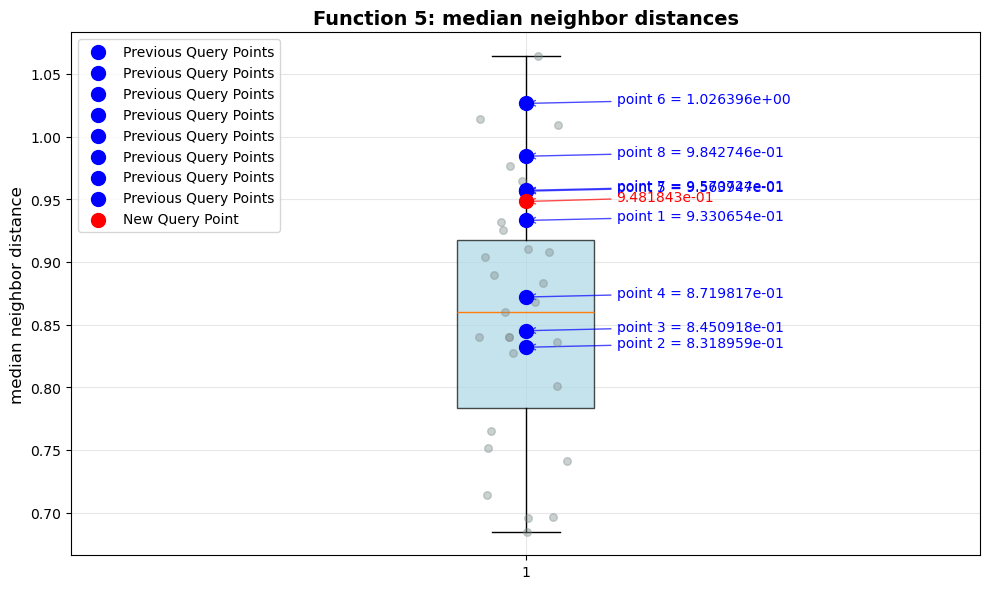

In [21]:
x5_distances = find_median_neighbor_distances(np.array(x_5))
new_x5_distance = np.array([find_median_distance_to_array(x_new[4], np.array(x_5))])
old_x5_distance = np.array([find_median_distance_to_array(x_5[-8], np.array(x_5)),find_median_distance_to_array(x_5[-7], np.array(x_5)), find_median_distance_to_array(x_5[-6], np.array(x_5)), find_median_distance_to_array(x_5[-5], np.array(x_5)), find_median_distance_to_array(x_5[-4], np.array(x_5)), find_median_distance_to_array(x_5[-3], np.array(x_5)), find_median_distance_to_array(x_5[-2], np.array(x_5)), find_median_distance_to_array(x_5[-1], np.array(x_5))])

plot_boxplot_with_new_point(
    x5_distances, 
    new_x5_distance,
    old_x5_distance, 
    'Function 5: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

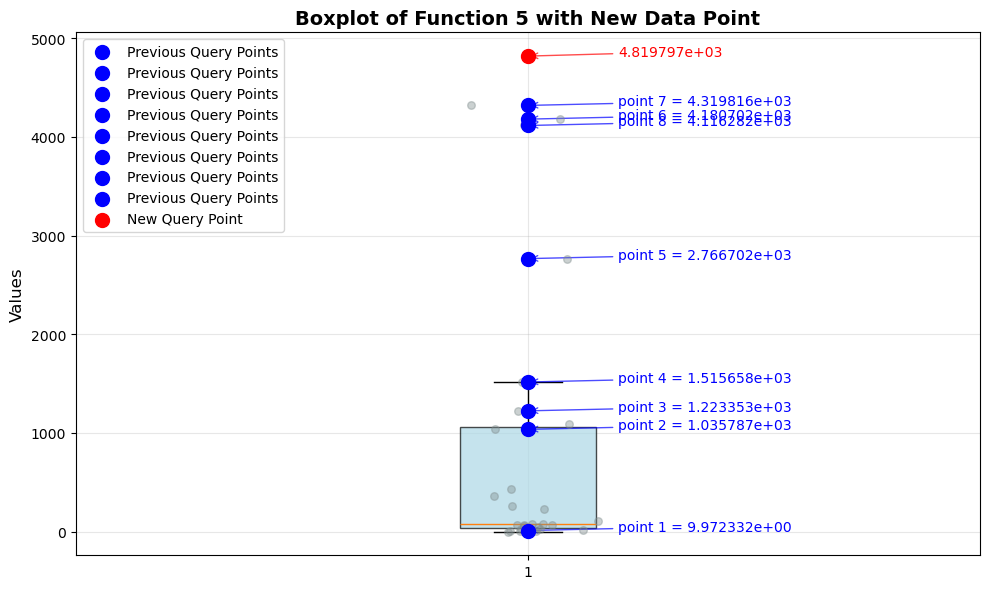

Old maximum: 4.319816e+03
New point: 4.819797e+03
Percentile rank in y_5: 100.0%

Old position: [0.339492 0.998909 0.989574 0.998768]
New position: [0.61346  0.998399 0.991291 0.999527]


In [23]:

plot_boxplot_with_new_point(
    y_5, 
    [y_new[4]], 
    np.array([y_5[-8], y_5[-7], y_5[-6], y_5[-5], y_5[-4], y_5[-3], y_5[-2], y_5[-1]]), 
    'Boxplot of Function 5 with New Data Point', 
    'Values', 
    overlay=True)

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_5):.6e}")
print(f"New point: {y_new[4]:.6e}")
print(f"Percentile rank in y_5: {100 * (y_5 < y_new[4]).sum() / len(y_5):.1f}%")
print(f"\nOld position: {x_5[np.argmax(y_5)]}")
print(f"New position: {x_new[4]}")

### Function 6

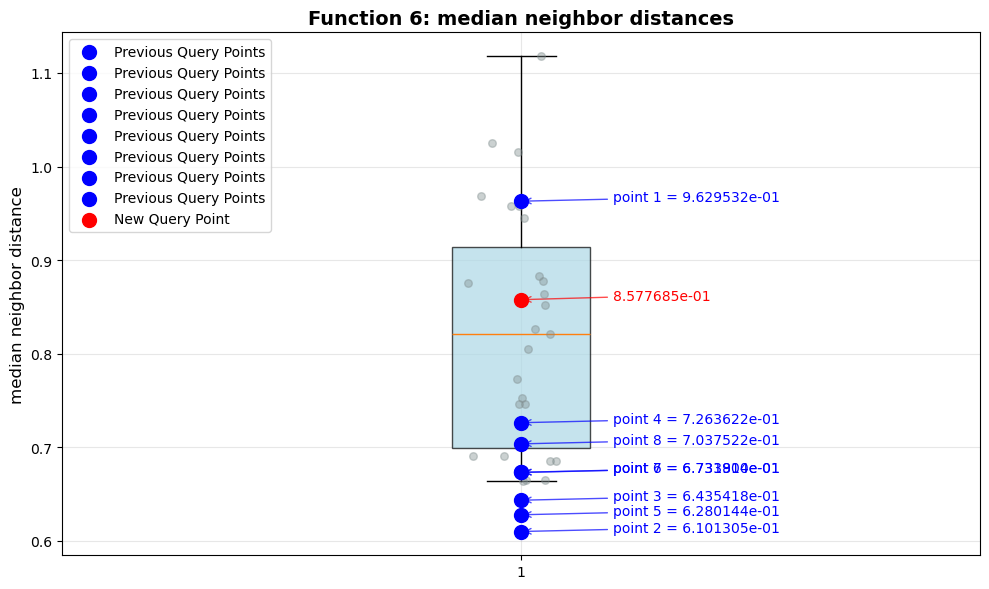

In [24]:
x6_distances = find_median_neighbor_distances(np.array(x_6))
new_x6_distance = np.array([find_median_distance_to_array(x_new[5], np.array(x_6))])
old_x6_distance = np.array([find_median_distance_to_array(x_6[-8], np.array(x_6)), find_median_distance_to_array(x_6[-7], np.array(x_6)), find_median_distance_to_array(x_6[-6], np.array(x_6)), find_median_distance_to_array(x_6[-5], np.array(x_6)), find_median_distance_to_array(x_6[-4], np.array(x_6)), find_median_distance_to_array(x_6[-3], np.array(x_6)), find_median_distance_to_array(x_6[-2], np.array(x_6)), find_median_distance_to_array(x_6[-1], np.array(x_6))])

plot_boxplot_with_new_point(
    x6_distances, 
    new_x6_distance,
    old_x6_distance, 
    'Function 6: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

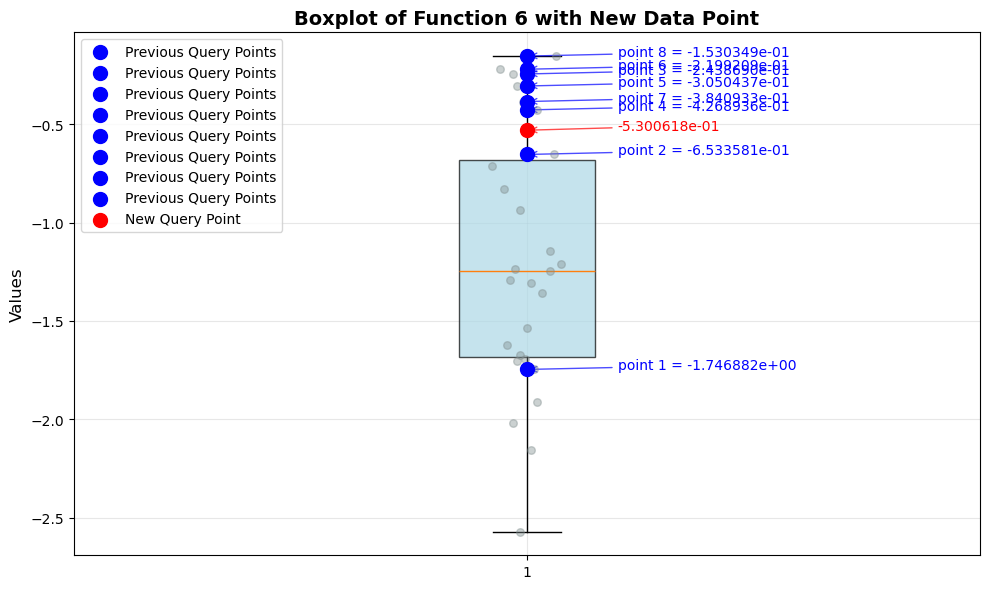

Old maximum: -1.530349e-01
New point: -5.300618e-01
Percentile rank in y_6: 77.8%

Old position: [0.370019 0.362352 0.616597 0.836408 0.06255 ]
New position: [0.245193 0.25039  0.624303 0.996633 0.001774]


In [25]:

plot_boxplot_with_new_point(
    y_6, 
    [y_new[5]], 
    np.array([y_6[-8], y_6[-7], y_6[-6], y_6[-5], y_6[-4], y_6[-3], y_6[-2], y_6[-1]]), 
    'Boxplot of Function 6 with New Data Point', 
    'Values', 
    overlay=True)

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_6):.6e}")
print(f"New point: {y_new[5]:.6e}")
print(f"Percentile rank in y_6: {100 * (y_6 < y_new[5]).sum() / len(y_6):.1f}%")
print(f"\nOld position: {x_6[np.argmax(y_6)]}")
print(f"New position: {x_new[5]}")

### Function 7

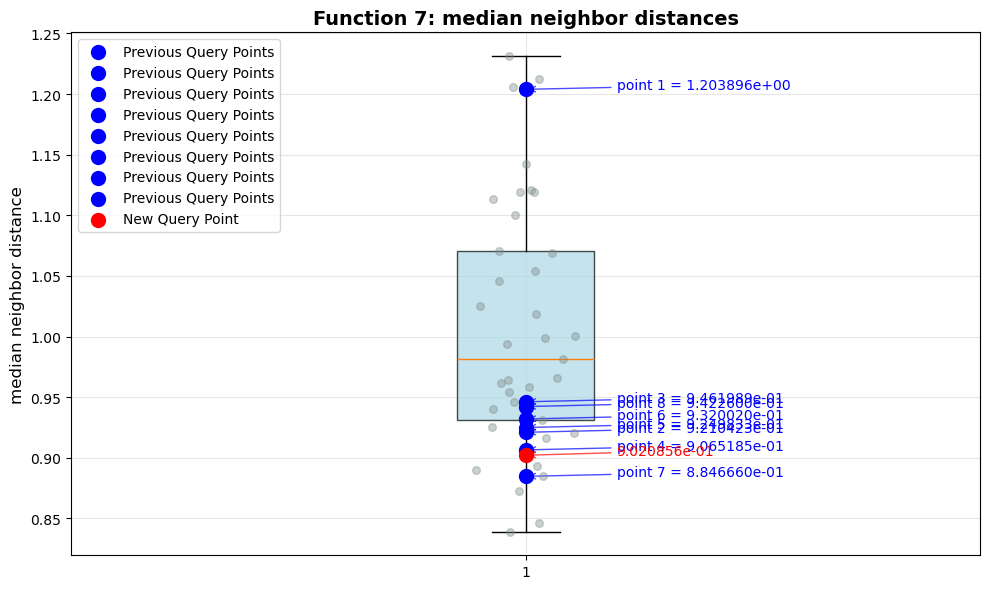

In [26]:
x7_distances = find_median_neighbor_distances(np.array(x_7))
new_x7_distance = np.array([find_median_distance_to_array(x_new[6], np.array(x_7))])
old_x7_distance = np.array([find_median_distance_to_array(x_7[-8], np.array(x_7)), find_median_distance_to_array(x_7[-7], np.array(x_7)), find_median_distance_to_array(x_7[-6], np.array(x_7)), find_median_distance_to_array(x_7[-5], np.array(x_7)), find_median_distance_to_array(x_7[-4], np.array(x_7)), find_median_distance_to_array(x_7[-3], np.array(x_7)), find_median_distance_to_array(x_7[-2], np.array(x_7)), find_median_distance_to_array(x_7[-1], np.array(x_7))])

plot_boxplot_with_new_point(
    x7_distances, 
    new_x7_distance,
    old_x7_distance, 
    'Function 7: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

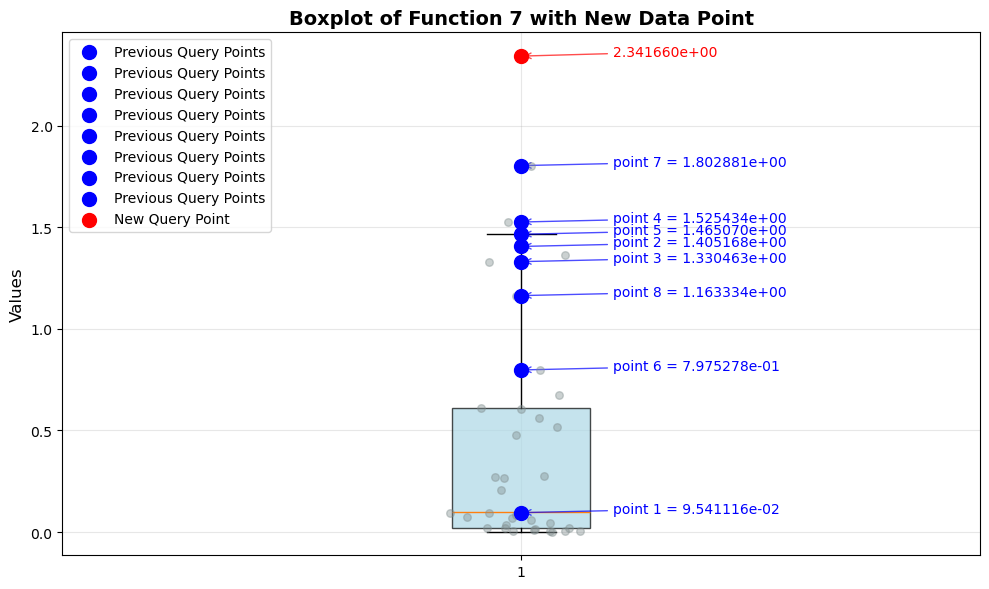

Old maximum: 1.802881e+00
New point: 2.341660e+00
Percentile rank in y_7: 100.0%

Old position: [0.049886 0.394235 0.196477 0.213189 0.247702 0.74906 ]
New position: [0.011133 0.236781 0.248012 0.199653 0.282008 0.660681]


In [27]:

plot_boxplot_with_new_point(
    y_7, 
    [y_new[6]], 
    np.array([y_7[-8], y_7[-7], y_7[-6], y_7[-5], y_7[-4], y_7[-3], y_7[-2], y_7[-1]]), 
    'Boxplot of Function 7 with New Data Point', 
    'Values', 
    overlay=True)

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_7):.6e}")
print(f"New point: {y_new[6]:.6e}")
print(f"Percentile rank in y_7: {100 * (y_7 < y_new[6]).sum() / len(y_7):.1f}%")
print(f"\nOld position: {x_7[np.argmax(y_7)]}")
print(f"New position: {x_new[6]}")

### Function 8

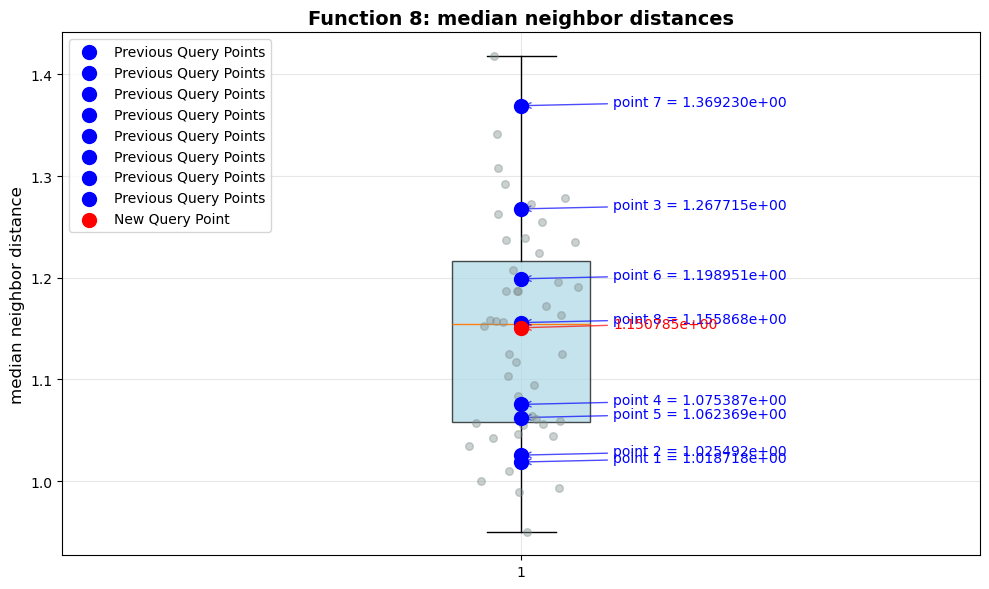

In [28]:
x8_distances = find_median_neighbor_distances(np.array(x_8))
new_x8_distance = np.array([find_median_distance_to_array(x_new[7], np.array(x_8))])
old_x8_distance = np.array([find_median_distance_to_array(x_8[-8], np.array(x_8)), find_median_distance_to_array(x_8[-7], np.array(x_8)), find_median_distance_to_array(x_8[-6], np.array(x_8)), find_median_distance_to_array(x_8[-5], np.array(x_8)), find_median_distance_to_array(x_8[-4], np.array(x_8)), find_median_distance_to_array(x_8[-3], np.array(x_8)), find_median_distance_to_array(x_8[-2], np.array(x_8)), find_median_distance_to_array(x_8[-1], np.array(x_8))])

plot_boxplot_with_new_point(
    x8_distances, 
    new_x8_distance,
    old_x8_distance, 
    'Function 8: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

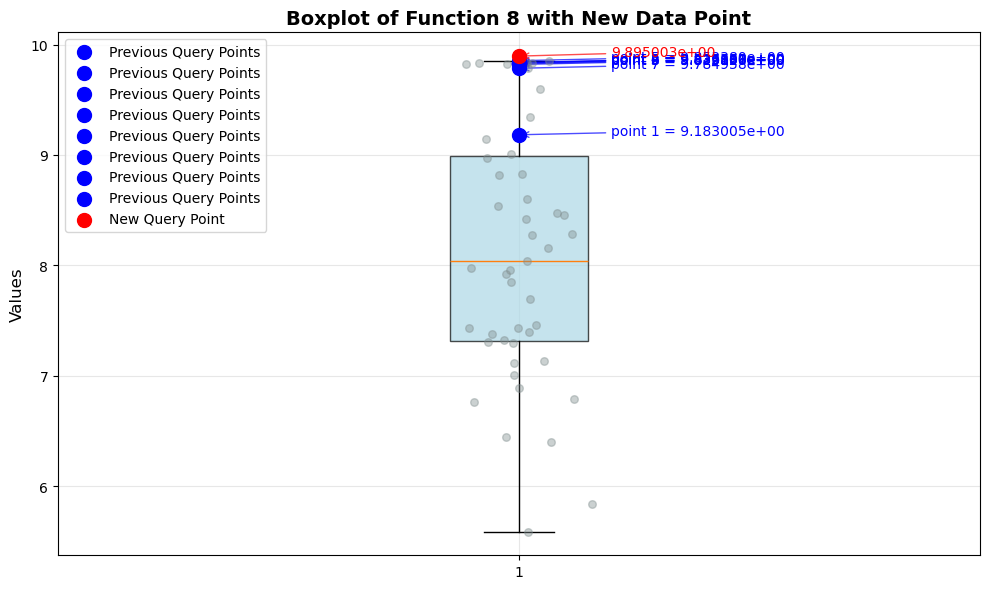

Old maximum: 9.853380e+00
New point: 9.895003e+00
Percentile rank in y_8: 100.0%

Old position: [0.086293 0.187309 0.013134 0.276036 0.636853 0.348756 0.360935 0.6105  ]
New position: [0.132329 0.155548 0.01355  0.267072 0.754837 0.29068  0.175114 0.444593]


In [29]:

plot_boxplot_with_new_point(
    y_8, 
    [y_new[7]], 
    np.array([y_8[-8], y_8[-7], y_8[-6], y_8[-5], y_8[-4], y_8[-3], y_8[-2], y_8[-1]]), 
    'Boxplot of Function 8 with New Data Point', 
    'Values', 
    overlay=True)

# Print some statistics for comparison
print(f"Old maximum: {np.max(y_8):.6e}")
print(f"New point: {y_new[7]:.6e}")
print(f"Percentile rank in y_8: {100 * (y_8 < y_new[7]).sum() / len(y_8):.1f}%")
print(f"\nOld position: {x_8[np.argmax(y_8)]}")
print(f"New position: {x_new[7]}")

# Add new data point

In [4]:
x_1 = np.concatenate((x_1, x_new[0].reshape(1, -1)))
y_1 = np.concatenate((y_1, np.array([y_new[0]])))

x_2 = np.concatenate((x_2, x_new[1].reshape(1, -1)))
y_2 = np.concatenate((y_2, np.array([y_new[1]])))

x_3 = np.concatenate((x_3, x_new[2].reshape(1, -1)))
y_3 = np.concatenate((y_3, np.array([y_new[2]])))

x_4 = np.concatenate((x_4, x_new[3].reshape(1, -1)))
y_4 = np.concatenate((y_4, np.array([y_new[3]])))

x_5 = np.concatenate((x_5, x_new[4].reshape(1, -1)))
y_5 = np.concatenate((y_5, np.array([y_new[4]])))

x_6 = np.concatenate((x_6, x_new[5].reshape(1, -1)))
y_6 = np.concatenate((y_6, np.array([y_new[5]])))

x_7 = np.concatenate((x_7, x_new[6].reshape(1, -1)))
y_7 = np.concatenate((y_7, np.array([y_new[6]])))

x_8 = np.concatenate((x_8, x_new[7].reshape(1, -1)))
y_8 = np.concatenate((y_8, np.array([y_new[7]])))


# Find new query points

## Function 1

In [31]:
# Fit GP

# apply Yeo-Johnson transformation to deal with skew when target has negatives and zeros
target_transform = PowerTransformer(method='yeo-johnson', standardize=True)

# kernel parameters
length_scale = 0.01
nu = 1.5

# set up evaluation grid:
x_11 = np.linspace(0, 1, 100)
x_12 = np.linspace(0, 1, 100)
x_11, x_12 = np.meshgrid(x_11, x_12)
x_1_grid = np.column_stack([x_11.ravel(), x_12.ravel()])

# Define and fit GP
kernel = (
    ConstantKernel(1, (1e-3, 1e3)) * 
    Matern(length_scale = length_scale, length_scale_bounds=(1e-3, 1e1), nu = nu)
    ) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-12, 1e-1)) # this allows the model to learn the noise level
base_gp = GaussianProcessRegressor(
    kernel = kernel, 
    normalize_y=False, 
    n_restarts_optimizer=10) # Already normalized target
# wrap the GP so it learns on the treansformed target
model = TransformedTargetRegressor(
    regressor=base_gp,
    transformer=target_transform
)

model.fit(np.array(x_1), np.array(y_1))


# Get the predicted (posterior) mean and standard deviation for each grid point
gp = model.regressor_
post_mean_transformed, post_std_transformed = gp.predict(x_1_grid, return_std = True)
post_mean = model.transformer_.inverse_transform(post_mean_transformed.reshape(-1, 1)).ravel()
post_std = model.transformer_.inverse_transform(post_std_transformed.reshape(-1, 1)).ravel()
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))


average posterior mean: -1.386799852547249e-05
average posterior standard deviation: 3.022814040935029e-05


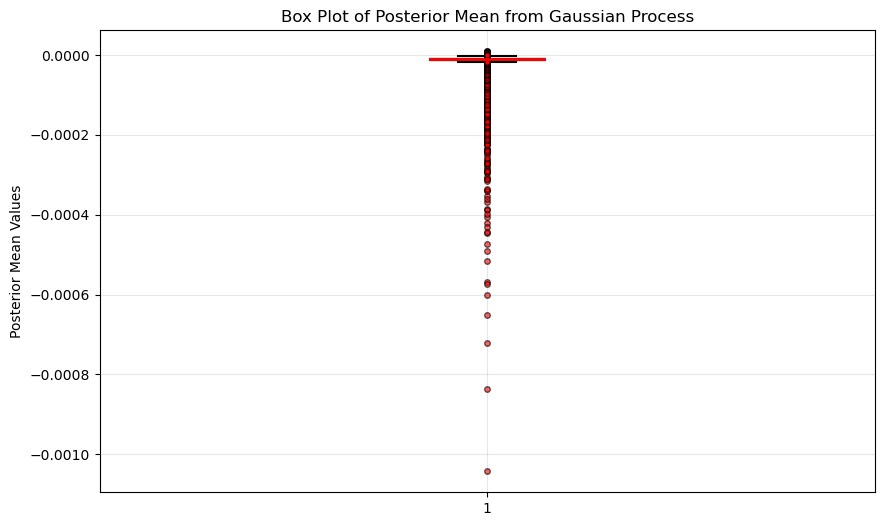

In [32]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

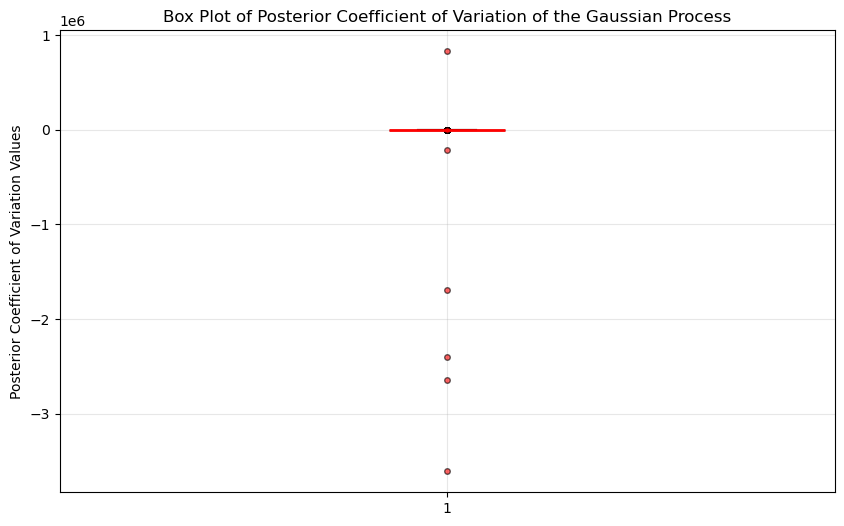

Median of the posterior coefficient of variation: -3.1330753688182904


In [33]:
# Create density plot of post_mean
cv = post_std / post_mean
plot_boxplot(
    cv[np.argsort(cv)[:-2]], # need to remove the 2 highest values to avoid outliers
    "Box Plot of Posterior Coefficient of Variation of the Gaussian Process", 
    "Posterior Coefficient of Variation Values")

print("Median of the posterior coefficient of variation:", np.median(cv))

**Week 16:**
The standard deviation is generally very high, so choose a $\kappa$ value higher than 1, giving slightly more weight to exploration.

**Week 17:**
Standard deviation is now much lower, but there are still some higher cv values. set kappa=1.5.

**Week 18:**
Very bad performance, decrease kappa to 1. 

**Week 19:**
Even worse performance, try increase kappa to 3. 

**Week 20:**
Performance is definitely better than last week but still not good. Increase kappa further to 6. 


**Week 21:**
Performance is much better than last week but still not at a max (although close). Increase kappa further to 8. 

In [34]:
# Calculate acquisition function

# Calculate the UCB aquisition function
kappa =  8
UCB = post_mean_transformed + kappa * post_std_transformed # NB acquisition function needs to be computed in the transformed space for best accuracy!

# Get the next query point
max_idx_1 = np.argmax(UCB)  
next_point_1 = x_1_grid[max_idx_1] 
print("Best known point:", x_1[np.argmax(y_1)])
print("Next query point:", round(next_point_1[0], 6), round(next_point_1[1], 6))

Best known point: [0.73102363 0.73299988]
Next query point: 0.050505 0.222222


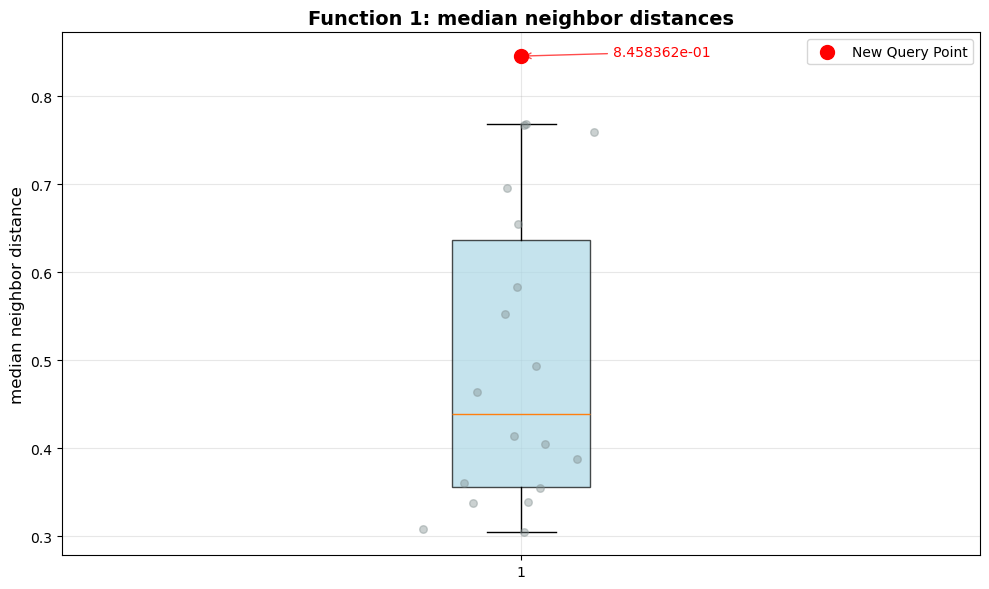

In [35]:
# check new distance compared to nearest neighbor distance
x1_distances = find_median_neighbor_distances(np.array(x_1))
new_x1_distance = np.array([find_median_distance_to_array(next_point_1, np.array(x_1))])

plot_boxplot_with_new_point(
    x1_distances, 
    new_x1_distance,
    np.array([]), 
    'Function 1: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

## Function 2

In [36]:
# GP assumption

# kernel parameters
length_scale = 0.01
nu = 1.5

# set up evaluation grid:
x_21 = np.linspace(0, 1, 100)
x_22 = np.linspace(0, 1, 100)
x_21, x_22 = np.meshgrid(x_21, x_22)
x_2_grid = np.column_stack([x_21.ravel(), x_22.ravel()])

# Define and fit GP
kernel = (
    ConstantKernel(1, (1e-3, 1e3)) * 
    Matern(length_scale = length_scale, length_scale_bounds=(1e-3, 1e1), nu = nu)
    ) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e-1)) # this allows the model to learn the noise level
model = GaussianProcessRegressor(
    kernel = kernel, 
    normalize_y = True, 
    n_restarts_optimizer = 10)
model.fit(np.array(x_2), np.array(y_2))


# Get the predicted (posterior) mean and standard deviation for each grid point
post_mean, post_std = model.predict(x_2_grid, return_std = True)
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))




average posterior mean: 0.2732395497743143
average posterior standard deviation: 0.21941937045000048


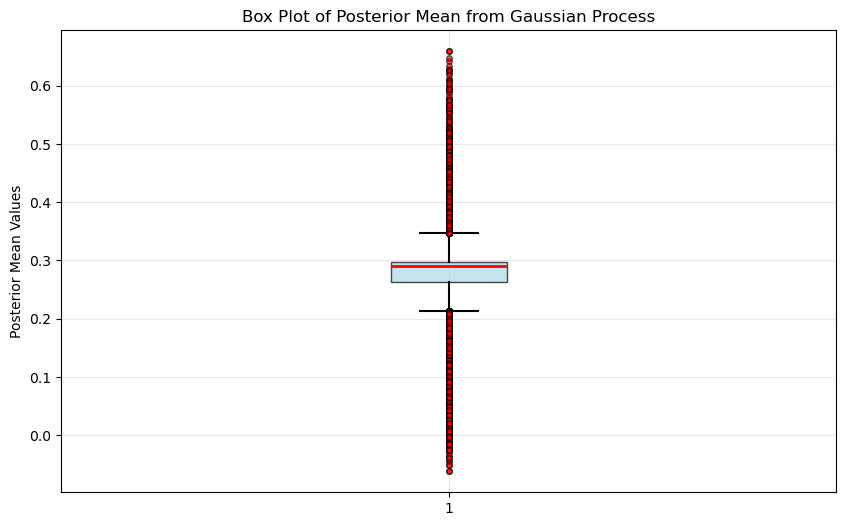

In [37]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

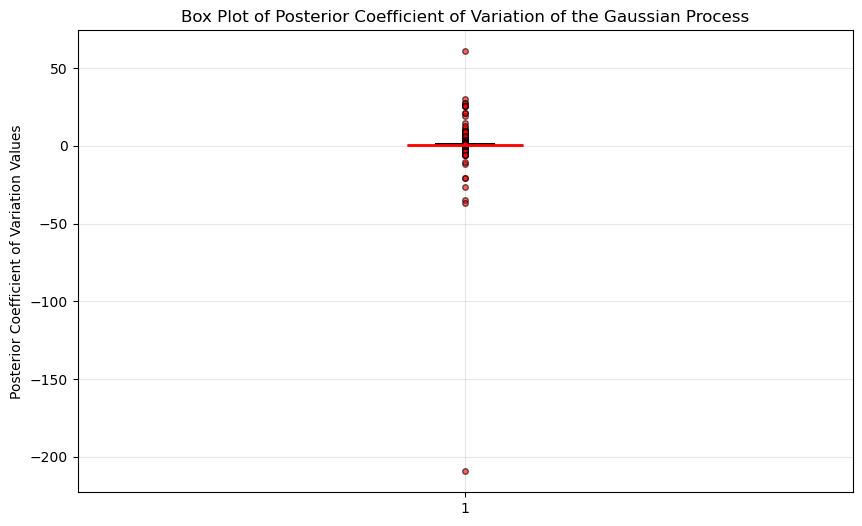

In [38]:
# Create density plot of post_mean
plot_boxplot(
    post_std / post_mean, 
    "Box Plot of Posterior Coefficient of Variation of the Gaussian Process", 
    "Posterior Coefficient of Variation Values")

**Week 17:** 
The standard deviation is relatively large, so I will choose a $\kappa$ value slightly greater than 1 to allow for slightly more exploration. 

**Week 18:** 
performance was ok, try increase kappa slightly. kappa = 3.

**Week 19:**
Performance even worse, but std is higher. So decrease kappa the slightly to 2.

**Week 20:**
Performance improved, but still not as good as week 18 (using code from week 17). Std has also decreased. So decrease kappa to 1.5. 

**Week 21:**
New maximum, and CV has decreased but still high. Keep kappa at 1.5.

In [39]:
# Calculate the UCB aquisition function
kappa =  1.5
UCB = post_mean + kappa * post_std

# Get the next query point
max_idx_2 = np.argmax(UCB)  
next_point_2 = x_2_grid[max_idx_2] 
print("Best known point:", x_2[np.argmax(y_2)])
print("Next query point:", round(next_point_2[0], 6), round(next_point_2[1], 6))

Best known point: [0.69697  0.111111]
Next query point: 0.686869 0.10101


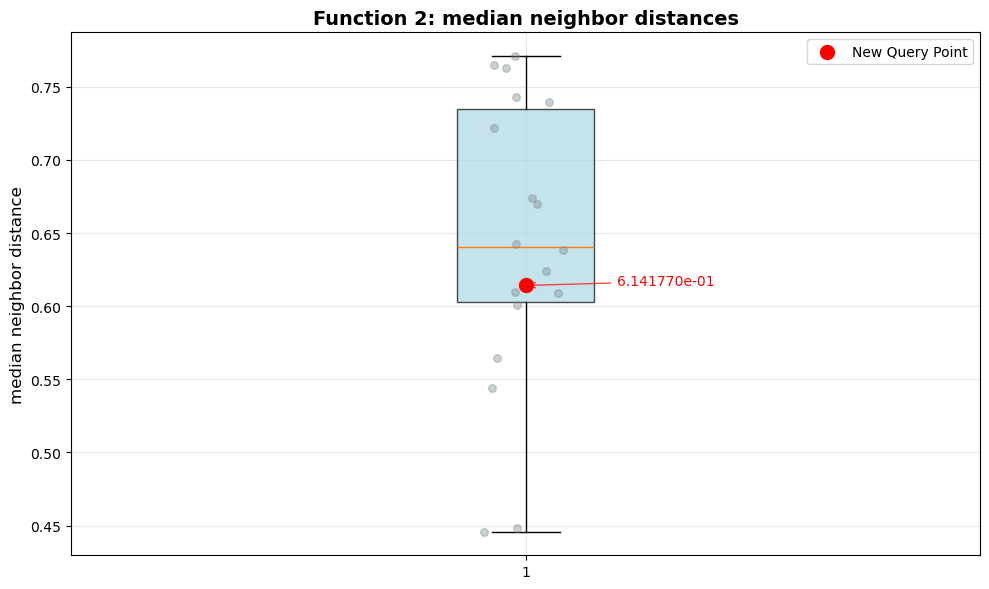

In [40]:
# check new distance compared to nearest neighbor distance
x2_distances = find_median_neighbor_distances(np.array(x_2))
new_x2_distance = np.array([find_median_distance_to_array(next_point_2, np.array(x_2))])

plot_boxplot_with_new_point(
    x2_distances, 
    new_x2_distance,
    np.array([]), 
    'Function 2: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)


## Function 3

In [41]:
# GP assumption


# apply Yeo-Johnson transformation to deal with skew when target has negatives and zeros
target_transform = PowerTransformer(method='yeo-johnson', standardize=True)

# kernel parameters
length_scale = 0.1
nu = 1.5

# set up evaluation grid:
x_31 = np.linspace(0, 1, 100)
x_32 = np.linspace(0, 1, 100)
x_33 = np.linspace(0, 1, 100)
x_31, x_32, x_33 = np.meshgrid(x_31, x_32, x_33)
x_3_grid = np.column_stack([x_31.ravel(), x_32.ravel(), x_33.ravel()])

# Define and fit GP
kernel = (
    ConstantKernel(1, (1e-3, 1e3)) * 
    Matern(length_scale = length_scale, length_scale_bounds=(1e-3, 1e1), nu = nu)
    ) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-12, 1e-1)) # this allows the model to learn the noise level
base_gp = GaussianProcessRegressor(
    kernel = kernel, 
    normalize_y=False, 
    n_restarts_optimizer=10) # Already normalized target
# wrap the GP so it learns on the treansformed target
model = TransformedTargetRegressor(
    regressor=base_gp,
    transformer=target_transform
)

model.fit(np.array(x_3), np.array(y_3))


# Get the predicted (posterior) mean and standard deviation for each grid point
gp = model.regressor_
post_mean_transformed, post_std_transformed = gp.predict(x_3_grid, return_std = True)
post_mean = model.transformer_.inverse_transform(post_mean_transformed.reshape(-1, 1)).ravel()
post_std = model.transformer_.inverse_transform(post_std_transformed.reshape(-1, 1)).ravel()
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))



average posterior mean: -0.0808806920822424
average posterior standard deviation: -0.03242935500521847


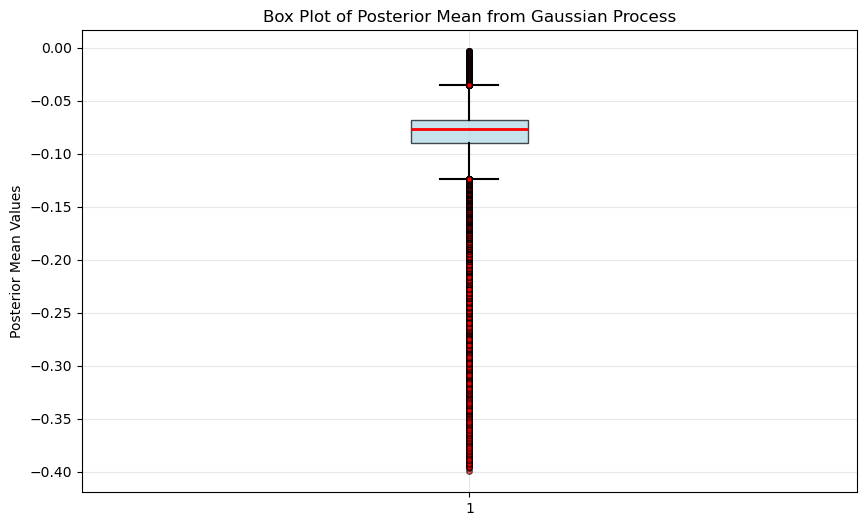

In [42]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

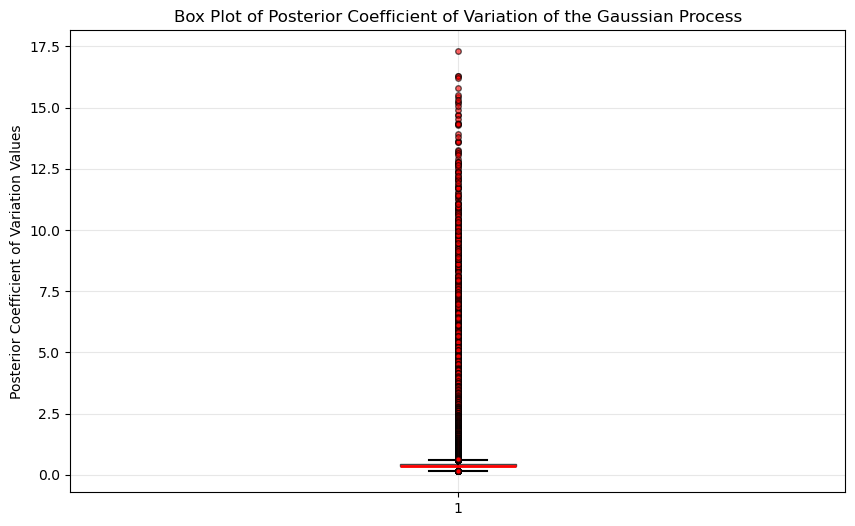

In [43]:
# Create density plot of post_mean
plot_boxplot(
    post_std / post_mean, 
    "Box Plot of Posterior Coefficient of Variation of the Gaussian Process", 
    "Posterior Coefficient of Variation Values")

**Week 18:** 
performance was good, keep everything the same.kappa =1.5

**Week 19:**
performance ok, decrease kappa to 1. 

**Week 20:**
Std has increased a fair amount. Querry point was a maximum, but not that much higher than previous max. So, increase kappa back to 1.5. 

**Week 21:**
Peformance not good, set kappa back to 1.

In [44]:

# Calculate the UCB aquisition function
kappa = 1
UCB = post_mean_transformed + kappa * post_std_transformed

# Get the next query point
max_idx_3 = np.argmax(UCB)  
next_point_3 = x_3_grid[max_idx_3] 
print("Best known point:", x_3[np.argmax(y_3)])
print("Next query point:", round(next_point_3[0], 6), round(next_point_3[1], 6), round(next_point_3[2], 6))


Best known point: [0.313131 0.454545 0.484848]
Next query point: 0.30303 0.484848 0.454545


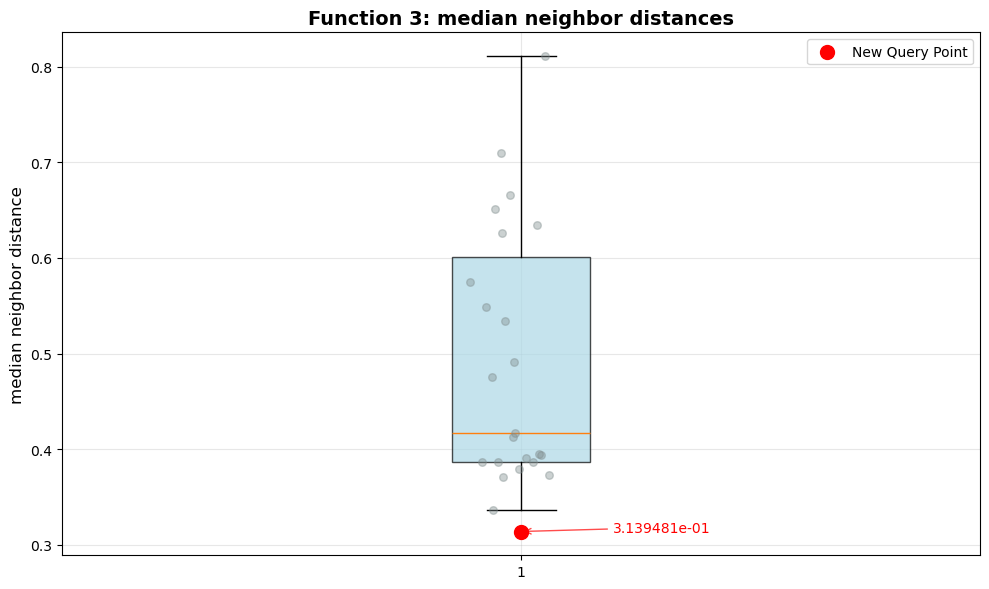

In [45]:
# check new distance compared to nearest neighbor distance
x3_distances = find_median_neighbor_distances(np.array(x_3))
new_x3_distance = np.array([find_median_distance_to_array(next_point_3, np.array(x_3))])

plot_boxplot_with_new_point(
    x3_distances, 
    new_x3_distance,
    np.array([]), 
    'Function 3: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

## Function 4

In [46]:
# GP assumption

# kernel parameters
length_scale = 0.1
nu = 1.5

x_4_grid = create_lhs_grid(n_samples=50**4, n_dimensions=4)

# Define and fit GP
kernel = (
    ConstantKernel(1, (1e-3, 1e3)) * 
    Matern(length_scale = length_scale, length_scale_bounds=(1e-3, 1e1), nu = nu)
    ) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e-1)) # this allows the model to learn the noise level
model = GaussianProcessRegressor(
    kernel = kernel, 
    normalize_y = True, 
    n_restarts_optimizer = 10)
model.fit(np.array(x_4), np.array(y_4))


# Get the predicted (posterior) mean and standard deviation for each grid point
post_mean, post_std = model.predict(x_4_grid, return_std = True)
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))




average posterior mean: -17.394861334218028
average posterior standard deviation: 1.9760337521086655


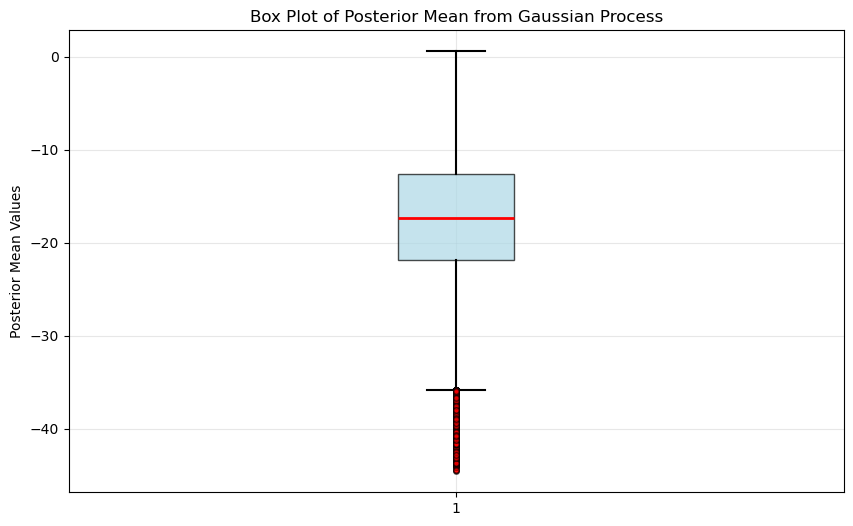

In [47]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

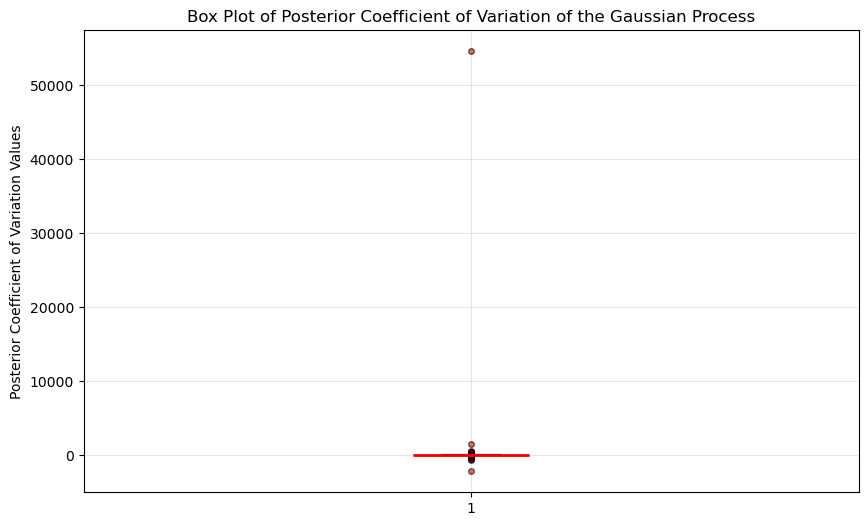

In [48]:
# Create density plot of post_mean
plot_boxplot(
    post_std / post_mean, 
    "Box Plot of Posterior Coefficient of Variation of the Gaussian Process", 
    "Posterior Coefficient of Variation Values")

**Week 16:** 
Even though the standard deviation is relatively low, set $\kappa$ higher than before because points have consistently been chosen very close together, and there has been little improvement. 

**Week 17:** 
Set $\kappa$ slightly lower than last week (was 1), since almost found the maximum and small sd suggests need to prioritise exploitation more. 

**Week 18:** 
There are some higher CVs now, so increase kappa to 3. 

**Week 19:**
performance was ok, and cv's are lower but still high. keep kappa the same.

**Week 20:**
Almost new max, but CVs have increased much more. Increase kappa to 3.5.

**Week 21:**
Almost new max, CV large, increase kappa to 5. 


In [49]:

# Calculate the UCB aquisition function
kappa = 5
UCB = post_mean + kappa * post_std


# Get the next query point
max_idx_4 = np.argmax(UCB)  
next_point_4 = x_4_grid[max_idx_4] 
print("Best known point:", x_4[np.argmax(y_4)])
print("Next query point:", round(next_point_4[0], 6), round(next_point_4[1], 6), round(next_point_4[2], 6), round(next_point_4[3], 6))


Best known point: [0.371491 0.387495 0.422577 0.413388]
Next query point: 0.00664 0.015851 0.9997 0.999946


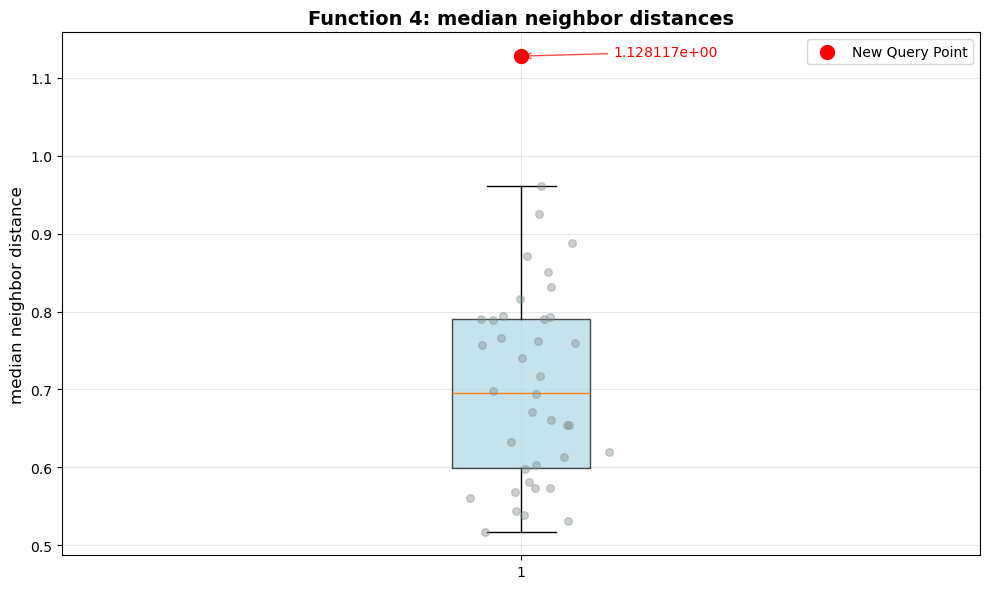

In [50]:
# check new distance compared to nearest neighbor distance
x4_distances = find_median_neighbor_distances(np.array(x_4))
new_x4_distance = np.array([find_median_distance_to_array(next_point_4, np.array(x_4))])

plot_boxplot_with_new_point(
    x4_distances, 
    new_x4_distance,
    np.array([]), 
    'Function 4: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

## Function 5

In [51]:

# GP assumption


# apply Yeo-Johnson transformation to deal with skew when target has negatives and zeros
target_transform = PowerTransformer(method='yeo-johnson', standardize=True)

# kernel parameters
length_scale = 0.1
nu = 1.5

# set up evaluation grid:
x_5_grid = create_lhs_grid(n_samples=50**4, n_dimensions=4)


# Define and fit GP
kernel = (
    ConstantKernel(1, (1e-3, 1e3)) * 
    Matern(length_scale = length_scale, length_scale_bounds=(1e-3, 1e1), nu = nu)
    ) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-12, 1e-1)) # this allows the model to learn the noise level
base_gp = GaussianProcessRegressor(
    kernel = kernel, 
    normalize_y=False, 
    n_restarts_optimizer=10) # Already normalized target
# wrap the GP so it learns on the treansformed target
model = TransformedTargetRegressor(
    regressor=base_gp,
    transformer=target_transform
)

model.fit(np.array(x_5), np.array(y_5))


# Get the predicted (posterior) mean and standard deviation for each grid point
gp = model.regressor_
post_mean_transformed, post_std_transformed = gp.predict(x_5_grid, return_std = True)
post_mean = model.transformer_.inverse_transform(post_mean_transformed.reshape(-1, 1)).ravel()
post_std = model.transformer_.inverse_transform(post_std_transformed.reshape(-1, 1)).ravel()
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))


average posterior mean: 158.9751380526425
average posterior standard deviation: 418.35326820715574


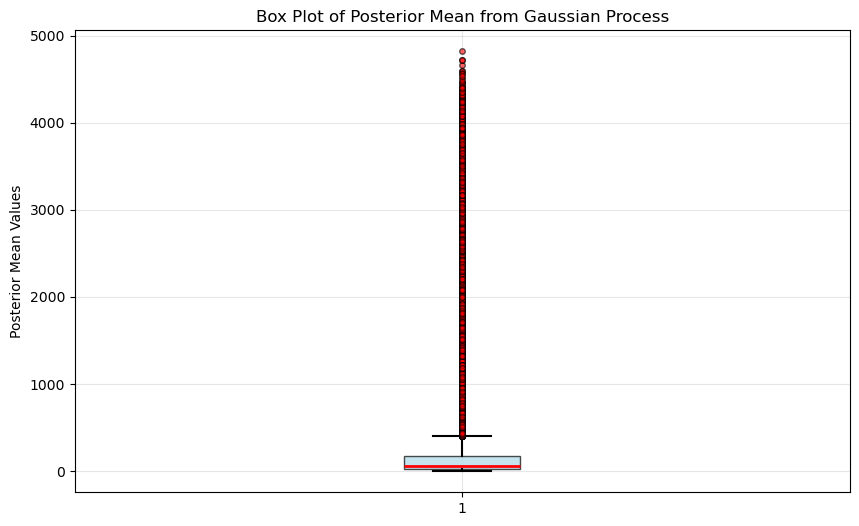

In [52]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

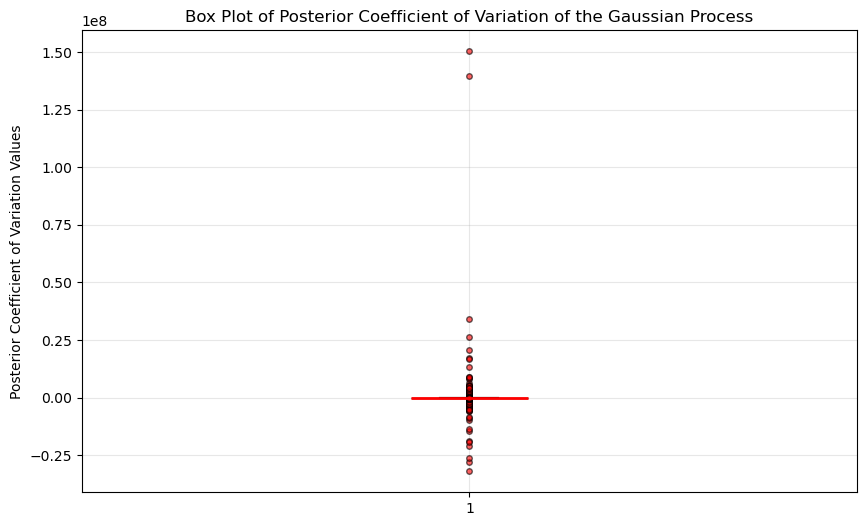

In [53]:
# Create density plot of post_mean
plot_boxplot(
    post_std / post_mean, 
    "Box Plot of Posterior Coefficient of Variation of the Gaussian Process", 
    "Posterior Coefficient of Variation Values")

**Week 16:** 
Decreased $\kappa$ slightly because CV decreased a lot. 

**Week 17:**
Keep $\kappa$ the same. 

**Week 18:** 
Performance last week was great and CV has decreased a lot. decrease kappa slightly to focus on exploitation. kappa = 0.5.

**Week 19:**
Performance was good but not as good as previously. CV has decreased a lot though. So keep kappa the same. 

**Week 20:**
Querry point was only third highest, first dip in performance in a while depsite big leaps early on. CV has also increased slightly. I still want to prioritise exploitation, but will increase kappa slightly to 0.7. 

**Week 21:**
New max, big improvement. Slight decrease in CV. Keep kappa same at 0.7.

In [54]:
# Calculate the UCB aquisition function
kappa = 0.7
UCB = post_mean_transformed + kappa * post_std_transformed


# Get the next query point
max_idx_5 = np.argmax(UCB)  
next_point_5 = x_5_grid[max_idx_5] 
print("Best known point:", x_5[np.argmax(y_5)])
print("Next query point:", round(next_point_5[0], 6), round(next_point_5[1], 6), round(next_point_5[2], 6), round(next_point_5[3], 6))

Best known point: [0.61346  0.998399 0.991291 0.999527]
Next query point: 0.874133 0.997528 0.996424 0.996103


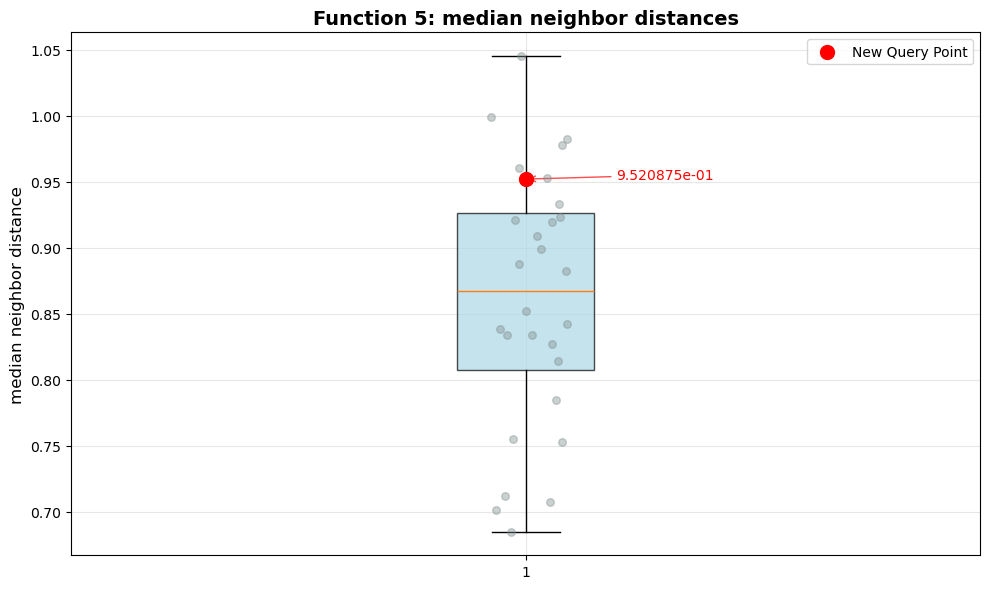

In [55]:

# check new distance compared to nearest neighbor distance
x5_distances = find_median_neighbor_distances(np.array(x_5))
new_x5_distance = np.array([find_median_distance_to_array(next_point_5, np.array(x_5))])

plot_boxplot_with_new_point(
    x5_distances, 
    new_x5_distance,
    np.array([]), 
    'Function 5: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

## Function 6

In [56]:
# GP assumption

# kernel parameters
length_scale = 0.1
nu = 1.5
# set up evaluation grid:
x_6_grid = create_lhs_grid(n_samples=30**5, n_dimensions=5)

# Define and fit GP
kernel = (
    ConstantKernel(1, (1e-3, 1e3)) * 
    Matern(length_scale = length_scale, length_scale_bounds=(1e-3, 1e1), nu = nu)
    ) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e-1)) # this allows the model to learn the noise level
model = GaussianProcessRegressor(
    kernel = kernel, 
    normalize_y = True, 
    n_restarts_optimizer = 10)
model.fit(np.array(x_6), np.array(y_6))


# Get the predicted (posterior) mean and standard deviation for each grid point
post_mean, post_std = model.predict(x_6_grid, return_std = True)
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))


average posterior mean: -1.4752936467152207
average posterior standard deviation: 0.2593132028127488


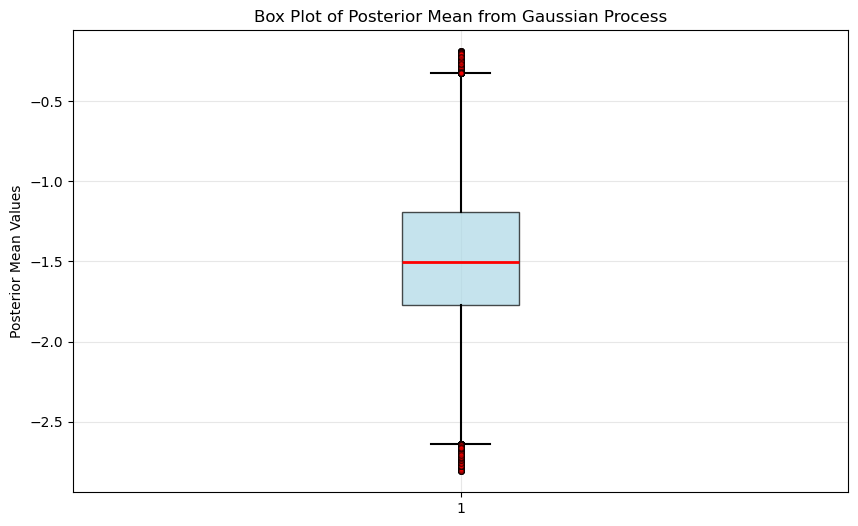

In [57]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

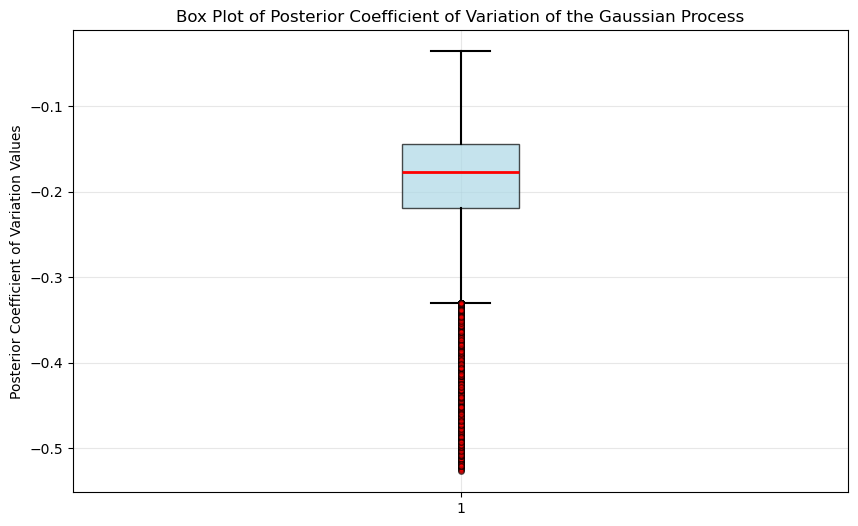

In [58]:
# Create density plot of post_mean
plot_boxplot(
    post_std / post_mean, 
    "Box Plot of Posterior Coefficient of Variation of the Gaussian Process", 
    "Posterior Coefficient of Variation Values")

**Week 16:** 
The standard deviation is relatively low, choose $\kappa$ to focus on exploitation.

**Week 17:** 
Keep $\kappa = 0.7$ the same.

**Week 18:** 
Keep $\kappa$ the same.

**Week 19:**
Performance not as good, CV increased slightly, increase kappa slightly to 0.8.

**Week 20:**
Found a new max, although not greatly larger than the previous max. Keep kappa as before. 

**Week 21:**
Performance not great, but CV has decreased. decrease kappa to 0.6.

In [59]:
# Calculate the UCB aquisition function
kappa = 0.6
UCB = post_mean + kappa * post_std

# Get the next query point
max_idx_6 = np.argmax(UCB)  
next_point_6 = x_6_grid[max_idx_6] 
print("Best known point:", x_6[np.argmax(y_6)])
print("Next query point:", round(next_point_6[0], 6), round(next_point_6[1], 6), round(next_point_6[2], 6), round(next_point_6[3], 6), round(next_point_6[4], 6))

Best known point: [0.370019 0.362352 0.616597 0.836408 0.06255 ]
Next query point: 0.401219 0.419311 0.608373 0.788712 0.070032


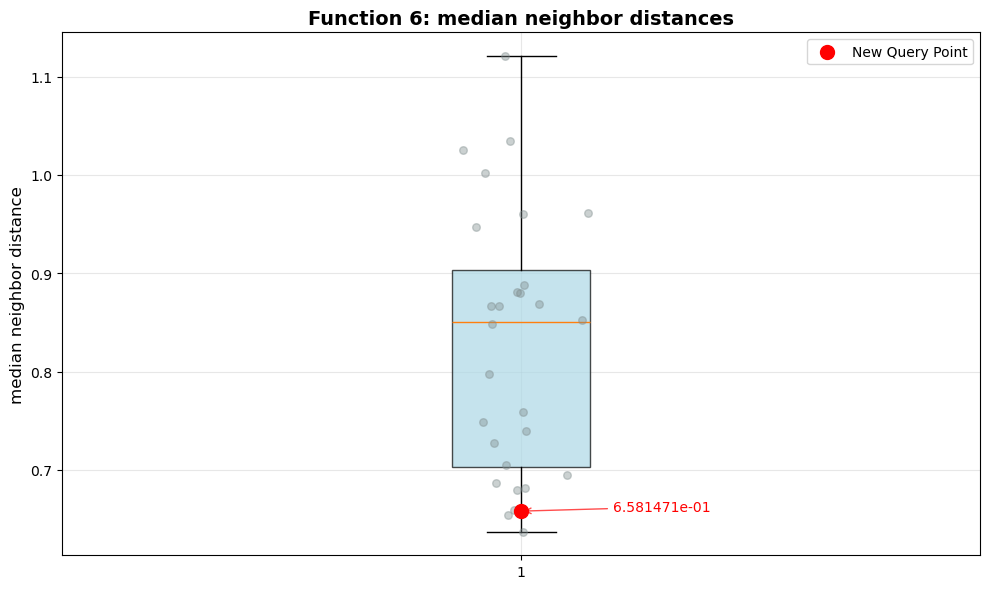

In [60]:
# check new distance compared to nearest neighbor distance
x6_distances = find_median_neighbor_distances(np.array(x_6))
new_x6_distance = np.array([find_median_distance_to_array(next_point_6, np.array(x_6))])

plot_boxplot_with_new_point(
    x6_distances, 
    new_x6_distance,
    np.array([]), 
    'Function 6: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

## Function 7

In [61]:
# GP assumption

# apply Yeo-Johnson transformation to deal with skew when target has negatives and zeros
target_transform = PowerTransformer(method='yeo-johnson', standardize=True)

# kernel parameters
length_scale = 0.1
nu = 1.5

# set up evaluation grid:
x_7_grid = create_lhs_grid(n_samples=15**6, n_dimensions=6)


# Define and fit GP
kernel = (
    ConstantKernel(1, (1e-3, 1e3)) * 
    Matern(length_scale = length_scale, length_scale_bounds=(1e-3, 1e1), nu = nu)
    ) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-12, 1e-1)) # this allows the model to learn the noise level
base_gp = GaussianProcessRegressor(
    kernel = kernel, 
    normalize_y=False, 
    n_restarts_optimizer=10) # Already normalized target
# wrap the GP so it learns on the treansformed target
model = TransformedTargetRegressor(
    regressor=base_gp,
    transformer=target_transform
)

model.fit(np.array(x_7), np.array(y_7))


# Get the predicted (posterior) mean and standard deviation for each grid point
gp = model.regressor_
post_mean_transformed, post_std_transformed = gp.predict(x_7_grid, return_std = True)
post_mean = model.transformer_.inverse_transform(post_mean_transformed.reshape(-1, 1)).ravel()
post_std = model.transformer_.inverse_transform(post_std_transformed.reshape(-1, 1)).ravel()
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))


average posterior mean: 0.1999950445783648
average posterior standard deviation: 0.49426205167717374


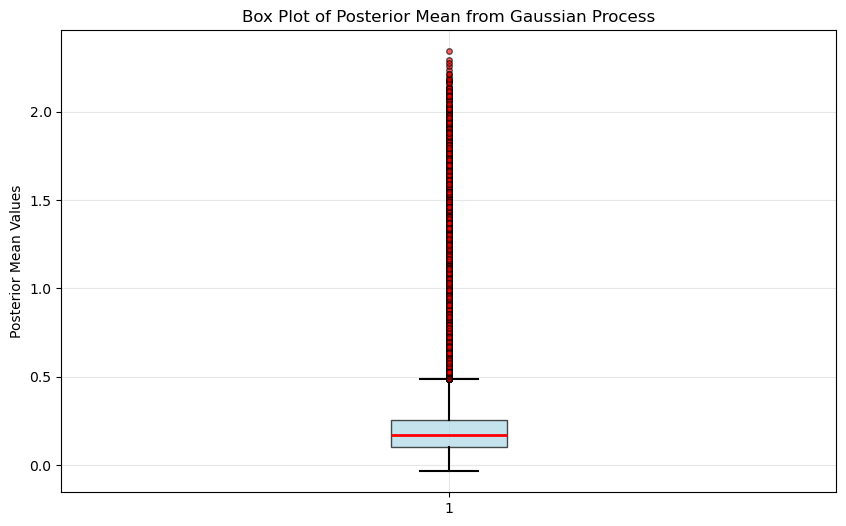

In [62]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

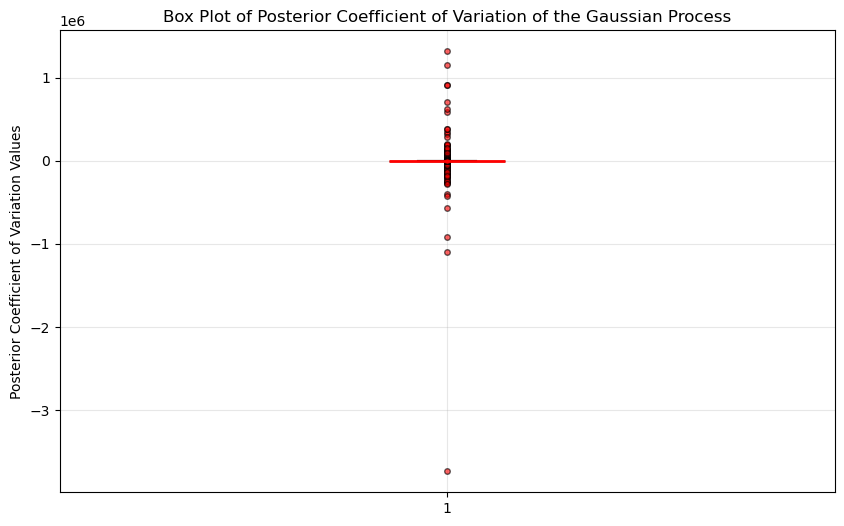

In [63]:

cv = post_std / post_mean
plot_boxplot(
    cv, # need to remove the highest value to avoid outliers
    "Box Plot of Posterior Coefficient of Variation of the Gaussian Process", 
    "Posterior Coefficient of Variation Values")

**Week 16:** 
Increase $\kappa$ slightly from before. 

**Week 17:** 
Keep $\kappa = 0.7$ same. 

**Week 18:** 
Keep $\kappa$ same. 

**Week 19:**
Performance very good, keep kappa same. 

**Week 20:**
Performance dropped and CV increased, increase kappa to 1. 

**Week 21:**
New maximmum, huge increase in performance. Keep kappa the same. 

In [64]:
# Calculate the UCB aquisition function
kappa = 1
UCB = post_mean_transformed + kappa * post_std_transformed

# Get the next query point
max_idx_7 = np.argmax(UCB)  
next_point_7 = x_7_grid[max_idx_7] 
print("Best known point:", x_7[np.argmax(y_7)])
print("Next query point:", round(next_point_7[0], 6), round(next_point_7[1], 6), round(next_point_7[2], 6), round(next_point_7[3], 6), round(next_point_7[4], 6), round(next_point_7[5], 6))

Best known point: [0.011133 0.236781 0.248012 0.199653 0.282008 0.660681]
Next query point: 0.004367 0.325745 0.296618 0.26978 0.278454 0.699361


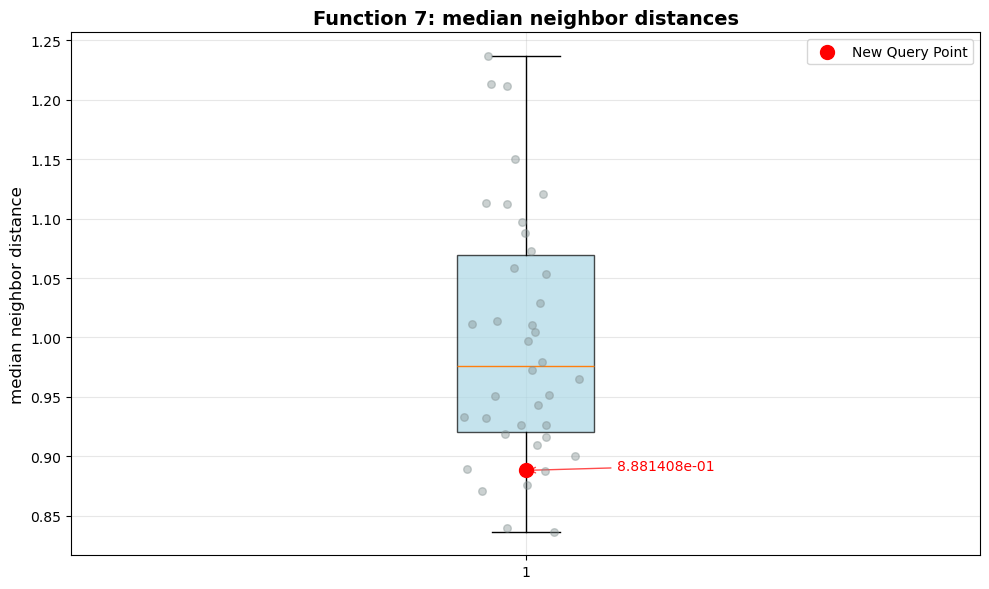

In [65]:
# check new distance compared to nearest neighbor distance
x7_distances = find_median_neighbor_distances(np.array(x_7))
new_x7_distance = np.array([find_median_distance_to_array(next_point_7, np.array(x_7))])

plot_boxplot_with_new_point(
    x7_distances, 
    new_x7_distance,
    np.array([]), 
    'Function 7: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

## Function 8

In [5]:

# GP assumption
noise_assumption = 1e-10

# kernel parameters
length_scale = 0.01
nu = 1.5

# set up evaluation grid:
x_8_grid = create_lhs_grid(n_samples=8**7, n_dimensions=8)

# Define and fit GP
kernel = (
    ConstantKernel(1, (1e-3, 1e3)) * 
    Matern(length_scale = length_scale, length_scale_bounds=(1e-3, 1e1), nu = nu)
    ) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-12, 1e-1)) # this allows the model to learn the noise level
model = GaussianProcessRegressor(
    kernel = kernel, 
    normalize_y = True, 
    n_restarts_optimizer = 10)
model.fit(np.array(x_8), np.array(y_8))

# Get the predicted (posterior) mean and standard deviation for each grid point
post_mean, post_std = model.predict(x_8_grid, return_std = True)
print("average posterior mean:", mean(post_mean))
print("average posterior standard deviation:", mean(post_std))


average posterior mean: 7.960885610177275
average posterior standard deviation: 0.22412212781737242


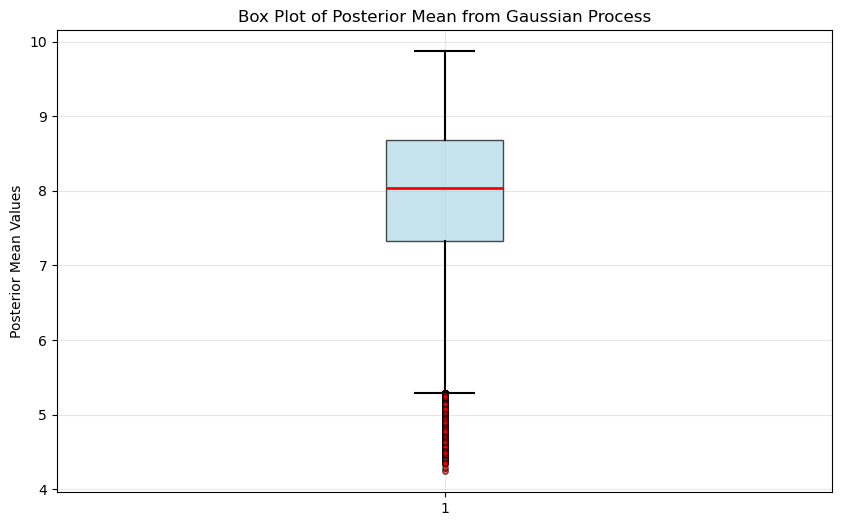

In [6]:
# Create density plot of post_mean
plot_boxplot(
    post_mean, 
    "Box Plot of Posterior Mean from Gaussian Process", 
    "Posterior Mean Values")

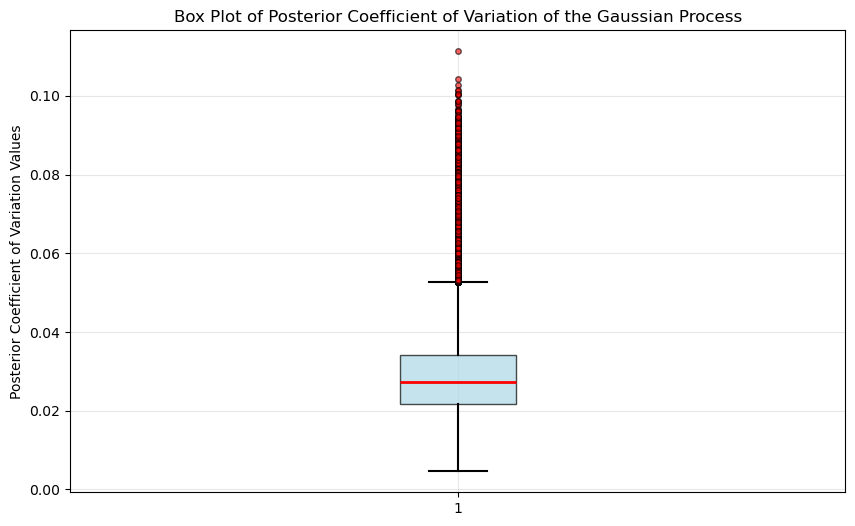

In [7]:

cv = post_std / post_mean
plot_boxplot(
    cv, # need to remove the highest value to avoid outliers
    "Box Plot of Posterior Coefficient of Variation of the Gaussian Process", 
    "Posterior Coefficient of Variation Values")

**Week 16:** 
The CV is extremely low, so I will choose a lower value for $\kappa$ that prioritises exploitation. 

**Week 17:** 
decrease $\kappa$ slightly to 0.3. 

**Week 18:** 
increase $\kappa$ slightly to 0.5 because performance wasn't great. 

**Week 19:**
Performance not bad, keep at 0.5.

**Week 20:**
Performance not bad, keep at 0.5.

**Week 21:**
New max, keep kappa =0.5. Note that kernel crashed, had to decrease dimensions of search area.

In [8]:
# Calculate the UCB aquisition function
kappa = 0.5
UCB = post_mean + kappa * post_std

# Get the next query point
max_idx_8 = np.argmax(UCB)  
next_point_8 = x_8_grid[max_idx_8] 
print("Best known point:", x_8[np.argmax(y_8)])
print("Next query point:", round(next_point_8[0], 6), round(next_point_8[1], 6), round(next_point_8[2], 6), round(next_point_8[3], 6), round(next_point_8[4], 6), round(next_point_8[5], 6), round(next_point_8[6], 6), round(next_point_8[7], 6))


Best known point: [0.132329 0.155548 0.01355  0.267072 0.754837 0.29068  0.175114 0.444593]
Next query point: 0.104929 0.214982 0.004292 0.107171 0.859369 0.177168 0.138629 0.40431


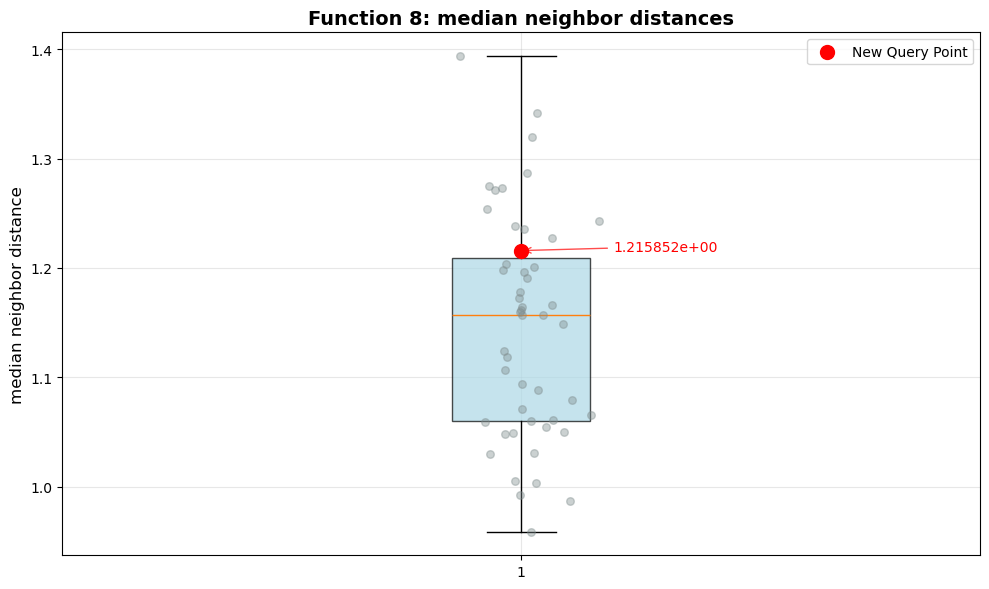

In [9]:
# check new distance compared to nearest neighbor distance
x8_distances = find_median_neighbor_distances(np.array(x_8))
new_x8_distance = np.array([find_median_distance_to_array(next_point_8, np.array(x_8))])

plot_boxplot_with_new_point(
    x8_distances, 
    new_x8_distance,
    np.array([]), 
    'Function 8: median neighbor distances', 
    'median neighbor distance', 
    overlay=True)

# Export Data

In [10]:
np.save("updated_data/week_21/function_1_inputs_week_21.npy", x_1)
np.save("updated_data/week_21/function_2_inputs_week_21.npy", x_2)
np.save("updated_data/week_21/function_3_inputs_week_21.npy", x_3)
np.save("updated_data/week_21/function_4_inputs_week_21.npy", x_4)
np.save("updated_data/week_21/function_5_inputs_week_21.npy", x_5)
np.save("updated_data/week_21/function_6_inputs_week_21.npy", x_6)
np.save("updated_data/week_21/function_7_inputs_week_21.npy", x_7)
np.save("updated_data/week_21/function_8_inputs_week_21.npy", x_8)

np.save("updated_data/week_21/function_1_outputs_week_21.npy", y_1)
np.save("updated_data/week_21/function_2_outputs_week_21.npy", y_2)
np.save("updated_data/week_21/function_3_outputs_week_21.npy", y_3)
np.save("updated_data/week_21/function_4_outputs_week_21.npy", y_4)
np.save("updated_data/week_21/function_5_outputs_week_21.npy", y_5)
np.save("updated_data/week_21/function_6_outputs_week_21.npy", y_6)
np.save("updated_data/week_21/function_7_outputs_week_21.npy", y_7)
np.save("updated_data/week_21/function_8_outputs_week_21.npy", y_8)